# Single Particle performance plots


   * [GEN Level plots](#Gen-level)
   * [All clusters without selection](#All-clusters-without-selection)
      * [2D clusters per layer](#2D-clusters-per-layer)
      * [2D cluster energy](#2D-cluster-energy)
      * [2D cluster: # of TriggerCells](#2D-cluster:-#-of-TriggerCells)
      * [# of 3D clusters](##-of-3D-clusters)
   * [Cluster matched to GEN particles](#Cluster-matched-to-GEN-particles)
      * [2D clusters per layer](#2D-clusters-per-layer)
      * [2D clusters: # of Trigger Cells](#2D-clusters:-#-of-Trigger-Cells)
      * [2D Cluster Energy](#2D-Cluster-Energy)
      * [3D clusters: # of 2D components](#3D-clusters:-#-of-2D-components)
      * [3D cluster energy](#3D-cluster-energy)
   * [Resolution studies](#Resolution-Studies)
      * [3D cluster: pt resolution](#3D-cluster:-Pt-resolution)
      * [2D position resolution](#Postion-resolution-of-2D-clusters)
   * [Trigger Tower performance](#Trigger-Tower-plots)
      * [Towers matched to GEN](#Towers-matched-to-GEN-particles)
      * [Resolution studies](#Trigger-Tower-resolution)



In [24]:
import sys
sys.path.insert(0, '..')
import ROOT
import root_numpy as rnp
import l1THistos as histos
import math
import uuid
import pandas as pd

ROOT.enableJSVis()
#ROOT.enableJSVis()

#from drawingTools import *

normalized_histos = list()
    

In [3]:
# %load ../drawingTools
import ROOT
import math
import uuid

# some useful globals, mainly to deal with ROOT idiosyncrasies
c_idx = 0
p_idx = 0
colors = range(1, 6)
stuff = []
f_idx = 0

ROOT.gStyle.SetPadBottomMargin(0.13)
ROOT.gStyle.SetPadLeftMargin(0.13)
ROOT.gStyle.SetPadRightMargin(0.30)

ROOT.gStyle.SetCanvasBorderMode(0)
ROOT.gStyle.SetCanvasColor(0)
ROOT.gStyle.SetCanvasDefH(600)
ROOT.gStyle.SetCanvasDefW(800)

# define some utility functions
def newCanvas(name=None, title=None, xdiv=0, ydiv=0, form=4):
    global c_idx
    if name is None:
        name = 'c_{}'.format(uuid.uuid4().hex[:6])
        c_idx += 1
    if title is None:
        title = name
    # print name, title
    canvas = ROOT.TCanvas(name, title)
    if(xdiv*ydiv != 0):
        canvas.Divide(xdiv, ydiv)
    global stuff
    stuff.append(canvas)
    return canvas


def draw(plot, options='', text=None):
    c = newCanvas()
    c.cd()
    plot.Draw(options)
    if text:
        rtext = getText(text, 0.15, 0.85)
        rtext.Draw('same')

    c.Draw()

    return


def getLegend(x1=0.7, y1=0.71, x2=0.95, y2=0.85):
    global stuff
    legend = ROOT.TLegend(x1, y1, x2, y2)
    stuff.append(legend)
    legend.SetFillColor(0)
    legend.SetFillStyle(0)
    legend.SetBorderSize(0)
    legend.SetTextSize(0.05)
    return legend


def drawAndProfileX(plot2d, miny=None, maxy=None, do_profile=True, options='', text=None):
    global p_idx
    if miny and maxy:
        plot2d.GetYaxis().SetRangeUser(miny, maxy)
    c = newCanvas()
    c.SetGrid(1, 1)
    c.cd()
    plot2d.Draw(options)
    ROOT.gPad.SetGrid(1, 1)
    ROOT.gStyle.SetGridColor(15)

    if do_profile:
        profname = plot2d.GetName()+'_prof_'+str(p_idx)
        p_idx += 1
        firstbin = 1
        lastbin = -1
        prof = plot2d.ProfileX(profname, firstbin, lastbin, 's')
        prof.SetMarkerColor(2)
        prof.SetLineColor(2)
        prof.Draw('same')

    if text:
        rtext = getText(text, 0.15, 0.85)
        rtext.Draw('same')

    c.Draw()


class Sample():
    def __init__(cls, name, label, version=None):
        cls.name = name
        cls.label = label
        if version:
            version = '_'+version
        else:
            version = ''
        cls.histo_filename = '../plots1/histos_{}{}.root'.format(cls.name, version)
        cls.histo_file = ROOT.TFile(cls.histo_filename)


def getText(text, ndc_x, ndc_y):
    global stuff
    rtext = ROOT.TLatex(ndc_x, ndc_y, text)
    stuff.append(rtext)
    rtext.SetNDC(True)
    # rtext.SetTextFont(40)
    rtext.SetTextSize(0.03)
    return rtext


def drawSame(histograms, labels, options='', norm=False, logy=False, min_y=None, max_y=None, text=None):
    global colors
    c = newCanvas(title=histograms[0].GetName())
    c.cd()
    leg = getLegend()

    max_value = max_y
    min_value = min_y
    if min_y is None:
        min_value = min([hist.GetBinContent(hist.GetMinimumBin()) for hist in histograms])
    if max_y is None:
        max_value = max([hist.GetBinContent(hist.GetMaximumBin()) for hist in histograms])*1.2

    for hidx, hist in enumerate(histograms):
        hist.SetLineColor(colors[hidx])
        hist.SetStats(False)
        if norm:
            hist.DrawNormalized('same'+','+options, 1.)
        else:
            if hidx:
                hist.Draw('same'+','+options)
            else:
                hist.Draw(options)
        leg.AddEntry(histograms[hidx], labels[hidx], 'l')

    histograms[0].GetYaxis().SetRangeUser(min_value, max_value)
    leg.Draw()
    c.Draw()
    if text:
        rtext = getText(text, 0.15, 0.85)
        rtext.Draw("same")
    if logy:
        c.SetLogy()


def drawProfileX(histograms, labels, options=''):
    profiles = [hist.ProfileX() for hist in histograms]
    drawSame(profiles, labels, options)


def drawSeveral(histograms, labels, options='', do_profile=False, miny=None, maxy=None, text=None):
    ydiv = int(math.ceil(float(len(histograms))/2))
    for hidx in range(0, len(histograms)):
        newtext = labels[hidx]
        if text:
            newtext = '{}: {}'.format(labels[hidx], text)
        if do_profile:
            drawAndProfileX(histograms[hidx], miny=miny, maxy=maxy, options=options, do_profile=do_profile, text=newtext)
        else:
            draw(histograms[hidx], options=options, text=newtext)


def drawProfileRatio(prof1, prof2, ymin=None, ymax=None, text=None):
    hist1 = prof1.ProjectionX(uuid.uuid4().hex[:6])
    hist2 = prof2.ProjectionX(uuid.uuid4().hex[:6])
    hist1.Divide(hist2)
    draw(hist1)
    if text:
        rtext = getText(text, 0.15, 0.85)
        rtext.Draw("same")

    if ymin is not None and ymax is not None:
        hist1.GetYaxis().SetRangeUser(ymin, ymax)
    ROOT.gPad.Update()


# mean+-nsigmas*RMS.
def drawGaussFit(histo, nsigmas, min, max):
    minfit = histo.GetMean() - nsigmas*histo.GetRMS()
    maxfit = histo.GetMean() + nsigmas*histo.GetRMS()
    drawGFit(histo, min, max, minfit, maxfit)


# Fit a histogram in the range (minfit, maxfit) with a gaussian and
# draw it in the range (min, max)
def drawGFit(histo, min, max, minfit, maxfit):
    # static int i = 0
    # i++
    # gPad->SetGrid(1,1);
    # gStyle->SetGridColor(15);
    histo.GetXaxis().SetRangeUser(min,max)
    global f_idx
    nameF1 = "g{}".format(f_idx)
    f_idx +=1
    g1 = ROOT.TF1(nameF1,"gaus",minfit,maxfit)
    g1.SetLineColor(2)
    g1.SetLineWidth(2)
    histo.Fit(g1,"R")



def drawGraphsSame(histograms, labels, options='', norm=False, logy=False, min_y=None, max_y=None, text=None):
    global colors
    c = newCanvas()
    c.cd()
    leg = getLegend()

    for hidx in range(0, len(histograms)):
        histograms[hidx].SetLineColor(colors[hidx])
        histograms[hidx].Draw('same'+','+options)
        leg.AddEntry(histograms[hidx], labels[hidx], 'l')

    leg.Draw()
    c.Draw()
    if logy:
        c.SetLogy()
    if text:
        rtext = getText(text, 0.15, 0.85)
        rtext.Draw("same")


In [4]:
version = 'v33'

#      Particle('ele', PID.electron),
#                  Particle('ele_A', PID.electron, '1.4 < abseta < 1.7'),
#                  Particle('ele_B', PID.electron, '1.7 <= abseta <= 2.8'),
#                  Particle('ele_C', PID.electron, 'abseta > 2.8'),
#                  Particle('photon', PID.photon),
#                  Particle('photon_A', PID.photon, '1.4 < abseta < 1.7'),
#                  Particle('photon_B', PID.photon, '1.7 <= abseta <= 2.8'),
#                  Particle('photon_C', PID.photon, 'abseta > 2.8'),
                
particles = ''

sample_names = ['ele_flat2to100_PU0',
                'ele_flat2to100_PU200',
                'photonPt35_PU0',
                'photonPt35_PU200']




sample_ele_flat2to100_PU0 = Sample('ele_flat2to100_PU0', 'PU0', version)
sample_ele_flat2to100_PU200 = Sample('ele_flat2to100_PU200', 'PU200', version)

sample_gPt35_PU0 = Sample('photonPt35_PU0', 'Pt35 PU0', version)
sample_gPt35_PU200 = Sample('photonPt35_PU200', 'Pt35 PU200', version)

sample_hadronGun_PU0 = Sample('hadronGun_PU0', 'PU0', version)
sample_hadronGun_PU200 = Sample('hadronGun_PU200', 'PU200', version)


samples_ele = [sample_ele_flat2to100_PU0,sample_ele_flat2to100_PU200]
samples_photon = [sample_gPt35_PU0,sample_gPt35_PU200]
samples_hadrons = [sample_hadronGun_PU0,sample_hadronGun_PU200]



samples = []



Error in <TFile::TFile>: file ../plots1/histos_photonPt35_PU0_v33.root does not exist
Error in <TFile::TFile>: file ../plots1/histos_photonPt35_PU200_v33.root does not exist


## Resolution Studies
### 3D cluster: Pt resolution

In [5]:

samples = samples_ele
tp_sets = ['DEF', 'DEF_em']
particles = ['ele', 'eleA', 'eleB', 'eleC']


tpset_labels = {'DEF' : 'NNDR',
                'DEF_em': 'NNDR + EGID'}


particle_labels = {'ele': 'all #eta',
                   'eleA' : '1.4 < |#eta| < 1.7',
                   'eleB' : '1.7 < |#eta| < 1.8',
                   'eleC' : '|#eta| > 2.8',}



labels = [sample.label for sample in samples]


histo_reso_df = pd.DataFrame(index=tp_sets, columns=particles)
titles_df = pd.DataFrame(index=tp_sets, columns=particles)
for tp_set in tp_sets:
    for particle in particles:
        histo_reso_df.loc[tp_set][particle] =  [histos.HistoSetReso('{}_{}'.format(tp_set, particle), sample.histo_file).hreso for sample in samples]
        titles_df.loc[tp_set, particle] = '{}, {}'.format(tpset_labels[tp_set], particle_labels[particle])
histo_reso_df

ele  \
DEF     [<ResoHistos h_reso_DEF_ele>, <ResoHistos h_re...   
DEF_em  [<ResoHistos h_reso_DEF_em_ele>, <ResoHistos h...   

                                                     eleA  \
DEF     [<ResoHistos h_reso_DEF_eleA>, <ResoHistos h_r...   
DEF_em  [<ResoHistos h_reso_DEF_em_eleA>, <ResoHistos ...   

                                                     eleB  \
DEF     [<ResoHistos h_reso_DEF_eleB>, <ResoHistos h_r...   
DEF_em  [<ResoHistos h_reso_DEF_em_eleB>, <ResoHistos ...   

                                                     eleC  
DEF     [<ResoHistos h_reso_DEF_eleC>, <ResoHistos h_r...  
DEF_em  [<ResoHistos h_reso_DEF_em_eleC>, <ResoHistos ...

In [ ]:
# dir(histo_reso_df.loc['DEF', 'ele'][0])


In [ ]:
# titles_df
# lat = ROOT.TLatex(); 
# lat.SetNDC()
# lat.SetTextSize(0.03)

# lat.SetTextColor(ROOT.kBlack)

# lat.DrawLatex(0.2, 0.75, 'mean: {v:.f}'.format(hist1.GetMean()))
# lat.DrawLatex(0.2, 0.71, '#sigma: {v:.f}'.format(hist1.GetMean()))



#### Matching to the highes pT cluster in DR 0.2 from GEN

In [ ]:
# ROOT.gStyle.SetPadTopMargin(0.05)
# ROOT.gStyle.SetPadTopMargin(0.13)
ROOT.gStyle.SetPadBottomMargin(0.13)
ROOT.gStyle.SetPadLeftMargin(0.13)
ROOT.gStyle.SetPadRightMargin(0.30)

ROOT.gStyle.SetCanvasBorderMode(0)
ROOT.gStyle.SetCanvasColor(0)
ROOT.gStyle.SetCanvasDefH(600)
ROOT.gStyle.SetCanvasDefW(800)


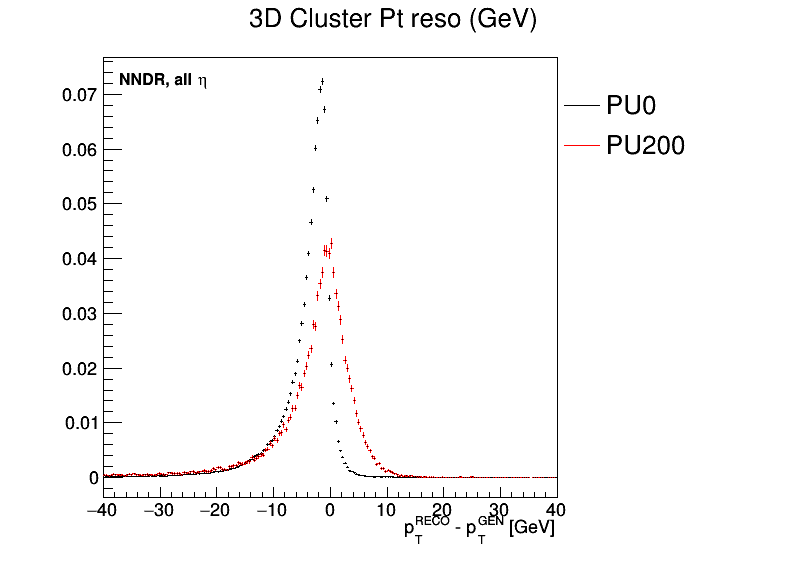

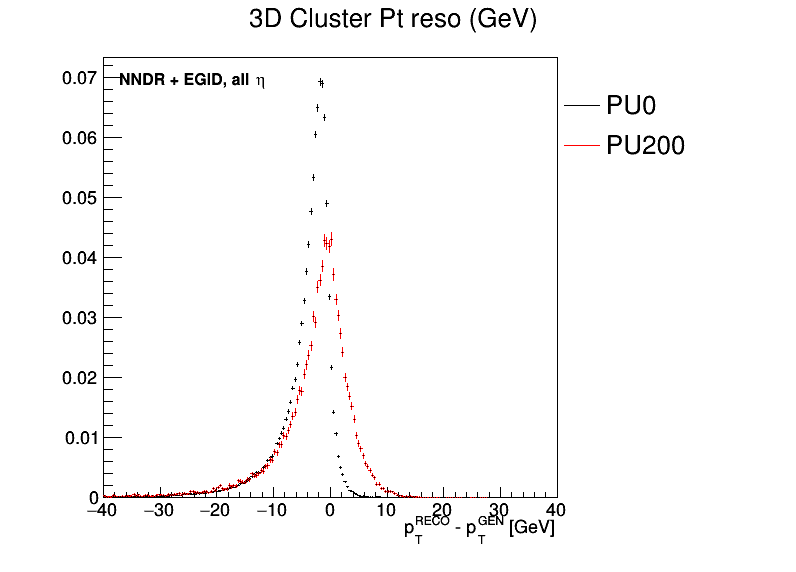

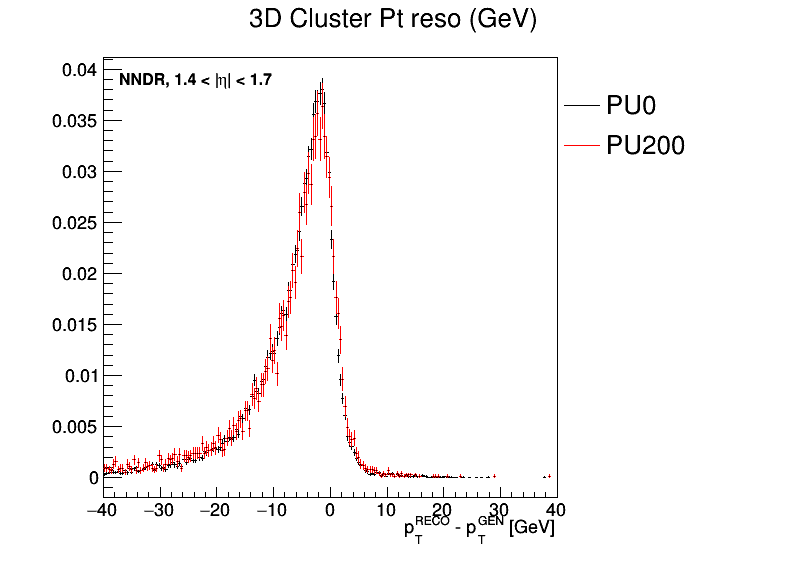

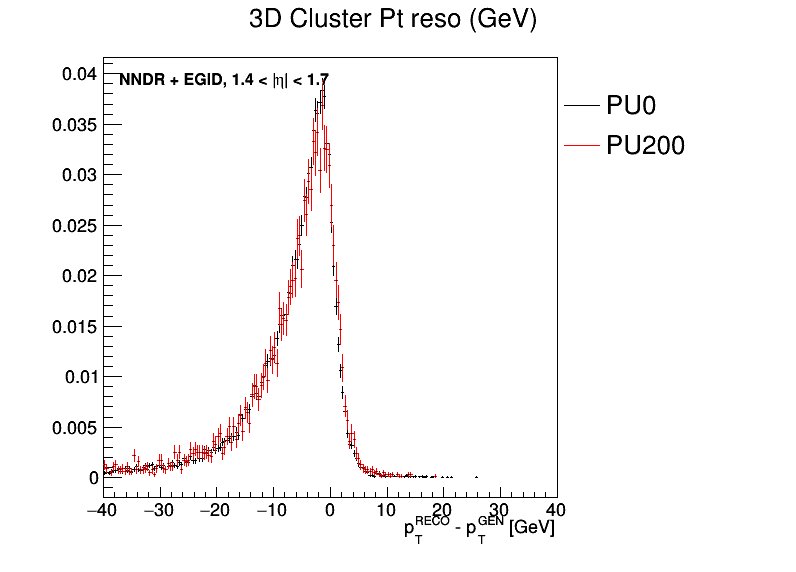

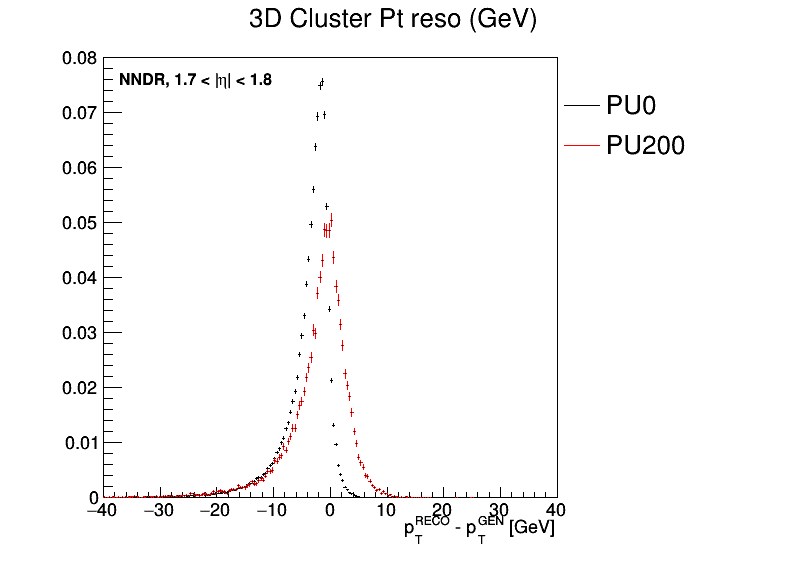

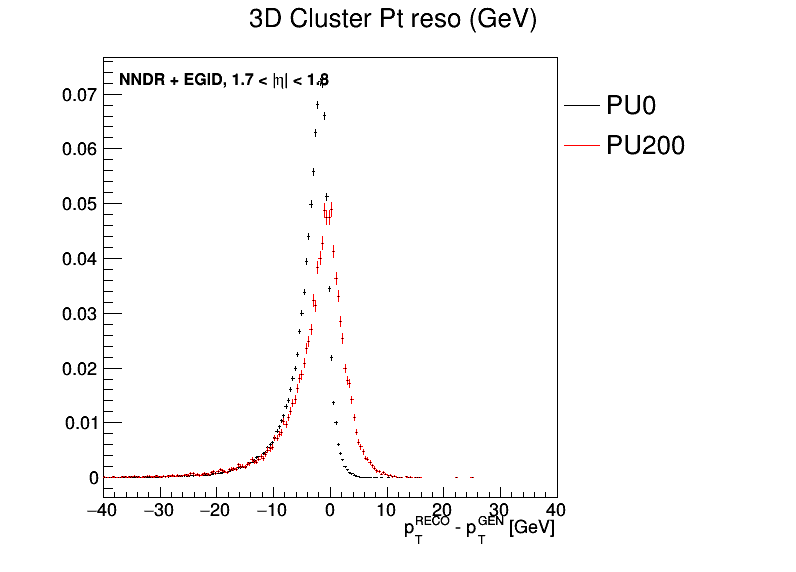

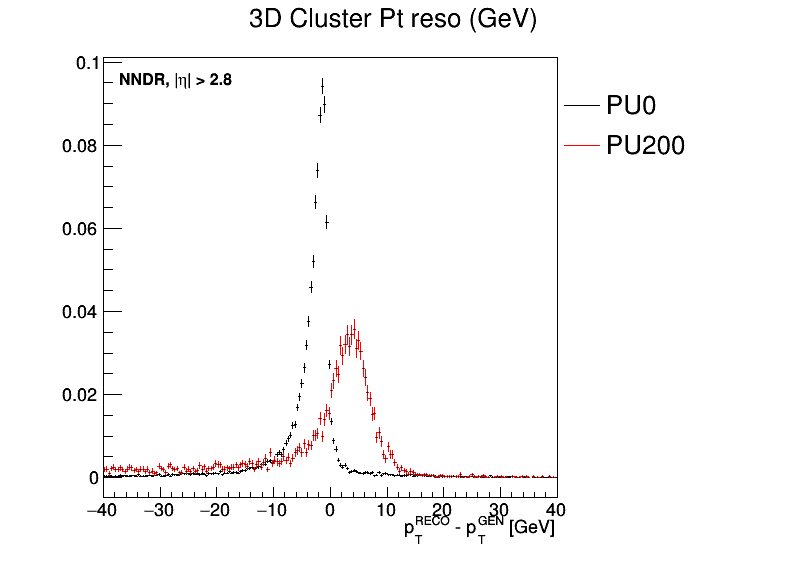

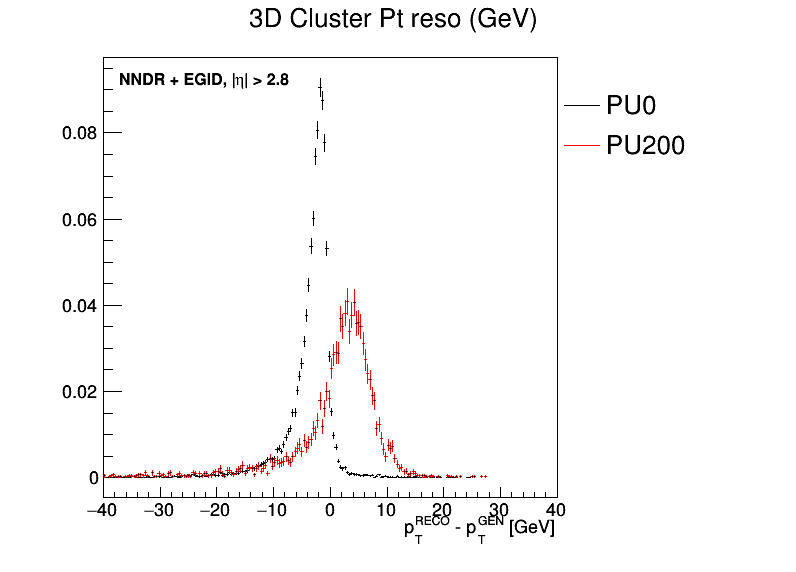

In [7]:
for particle in particles:
    for tp_set in ['DEF', 'DEF_em']:
        hByTPset = [histo.h_ptRes for histo in histo_reso_df.loc[tp_set, particle]]
        drawSame(hByTPset, labels, norm=True, text=titles_df.loc[tp_set, particle])


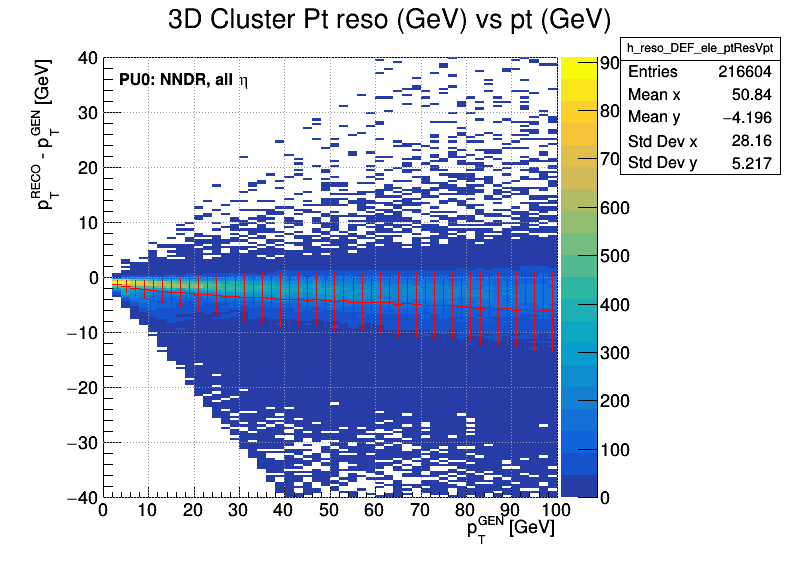

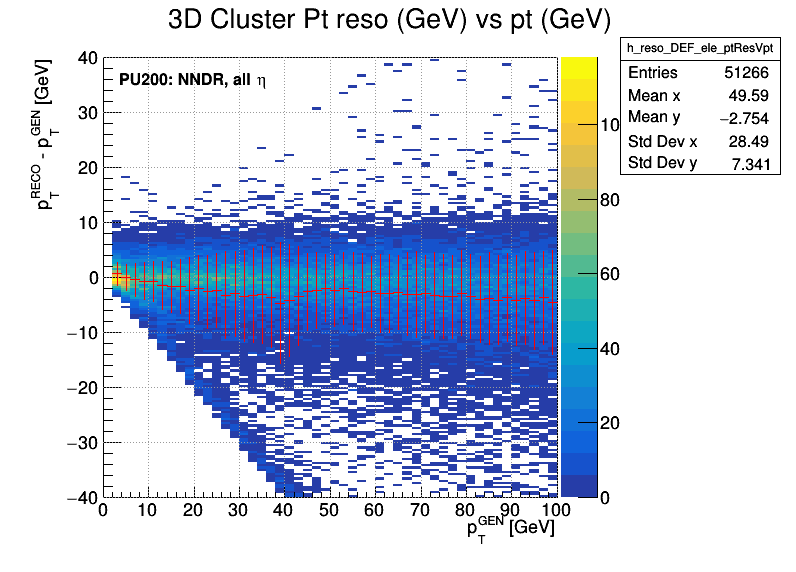

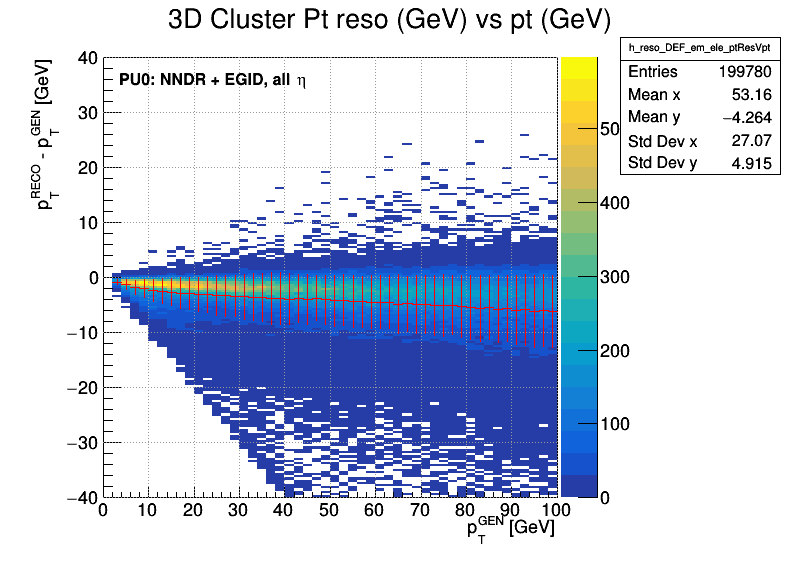

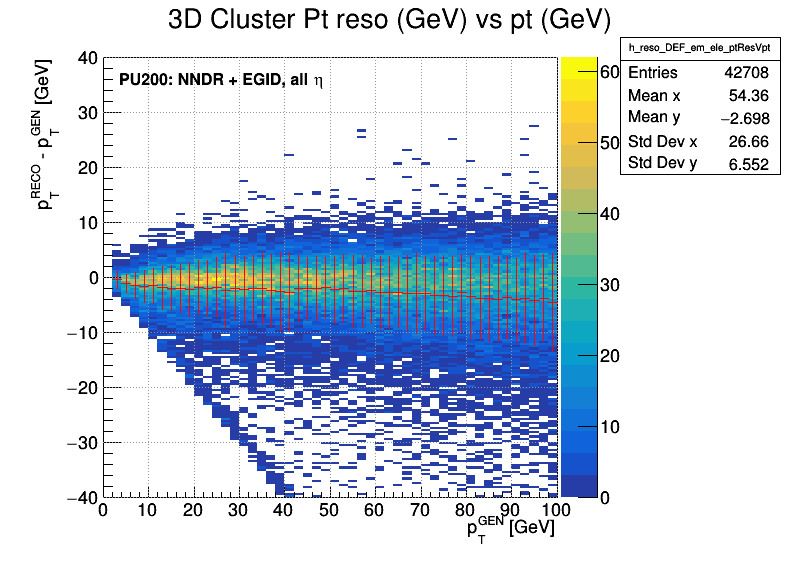

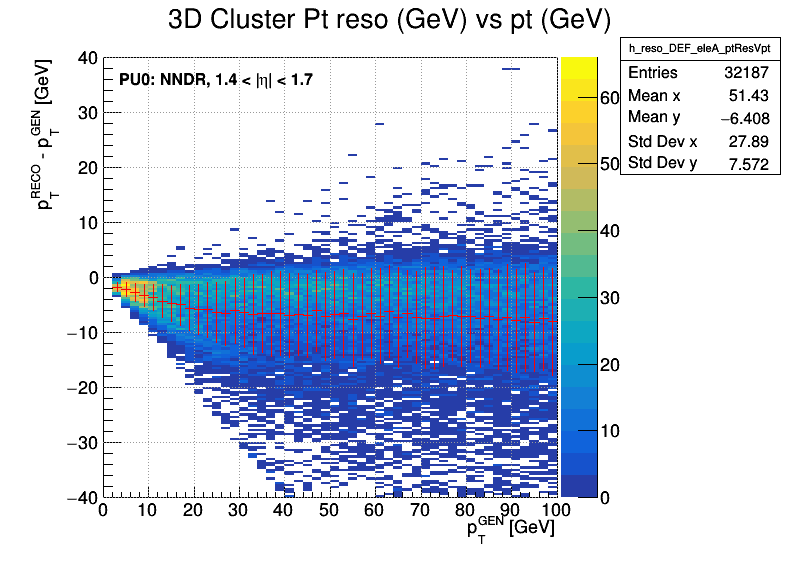

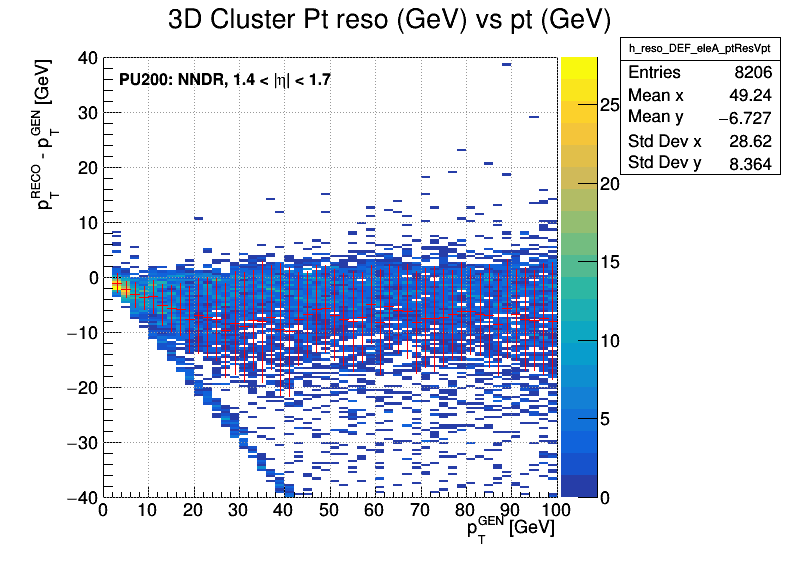

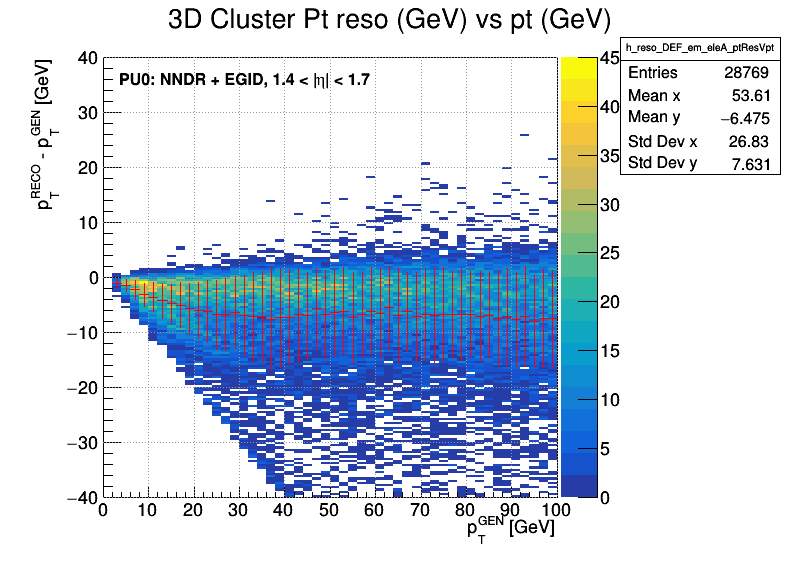

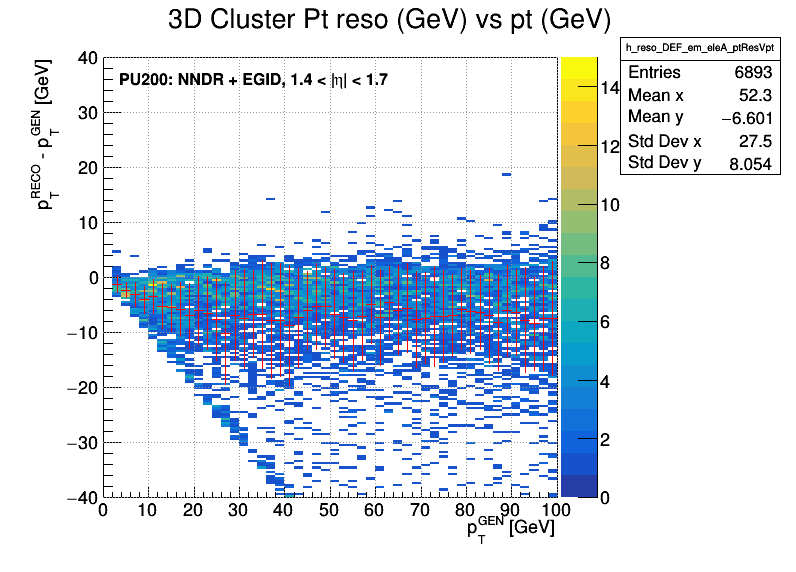

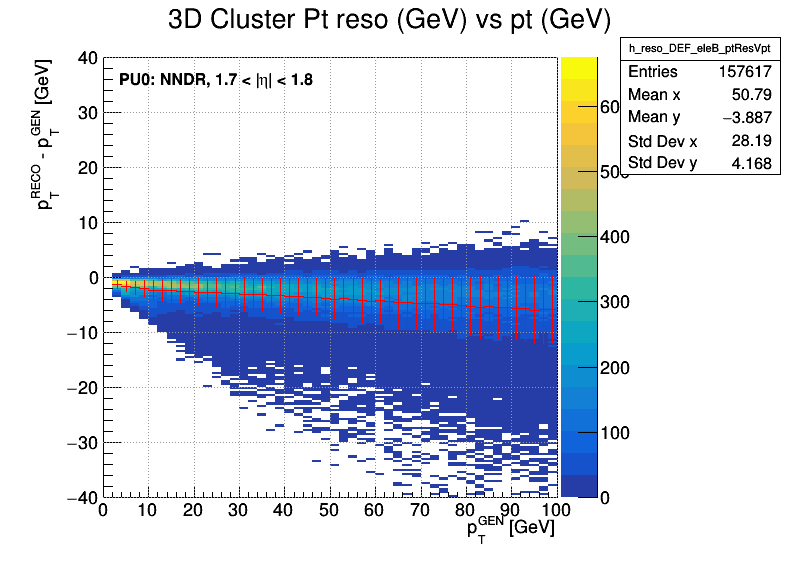

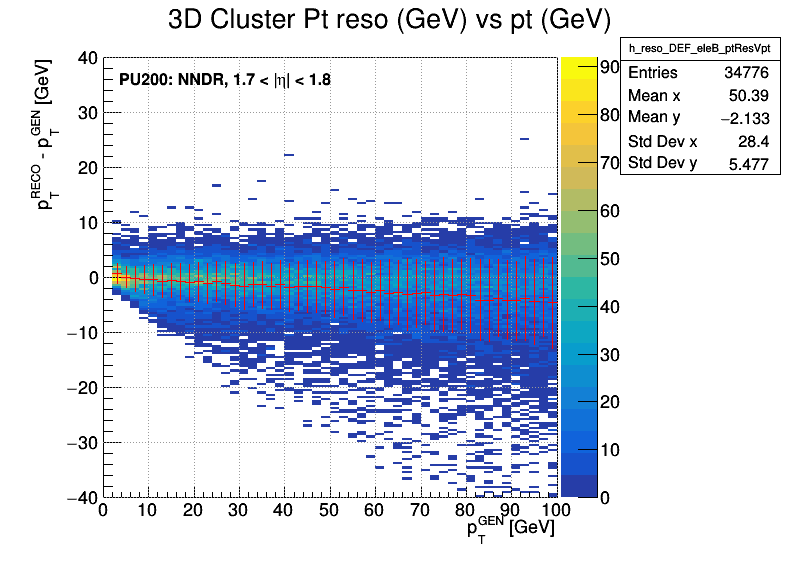

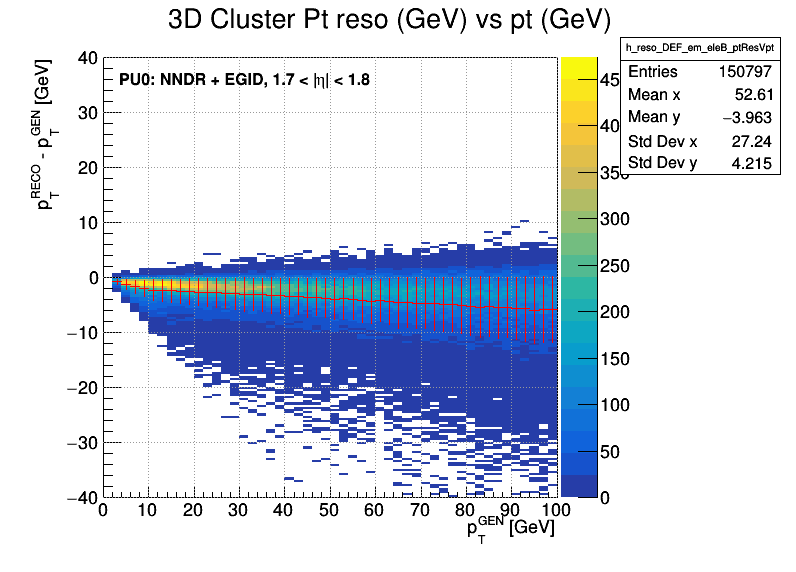

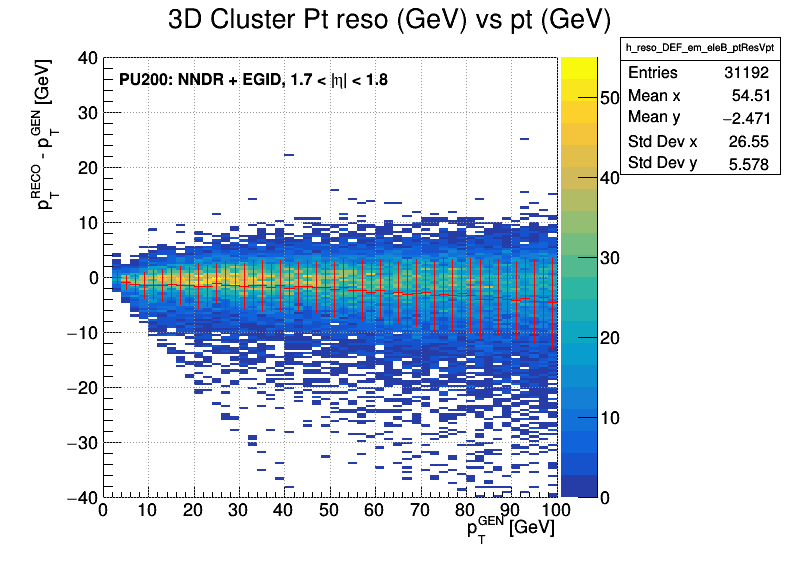

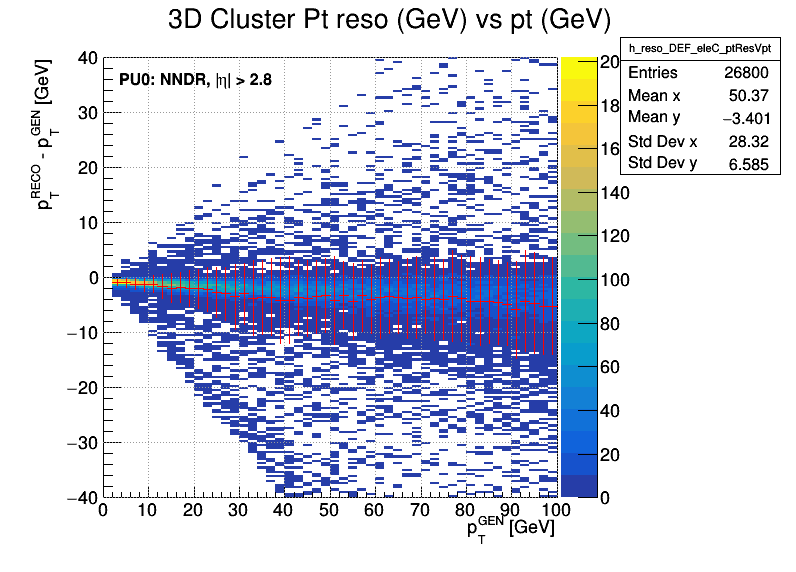

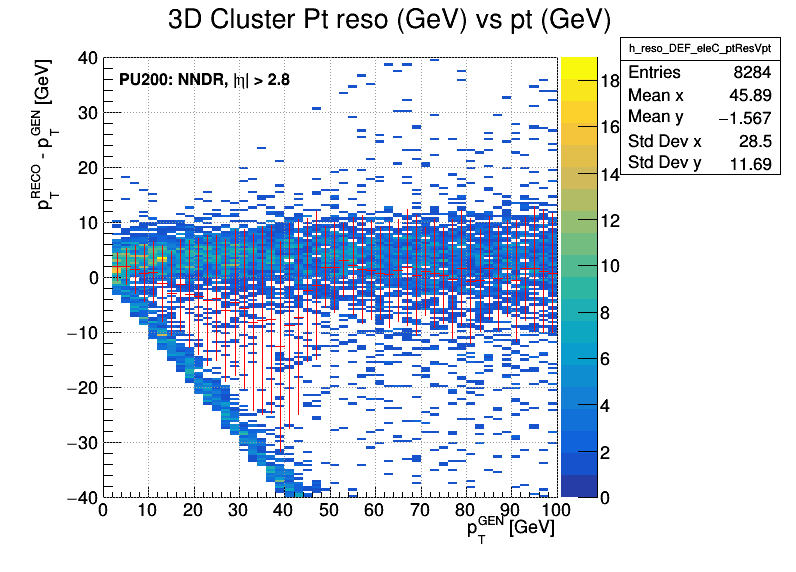

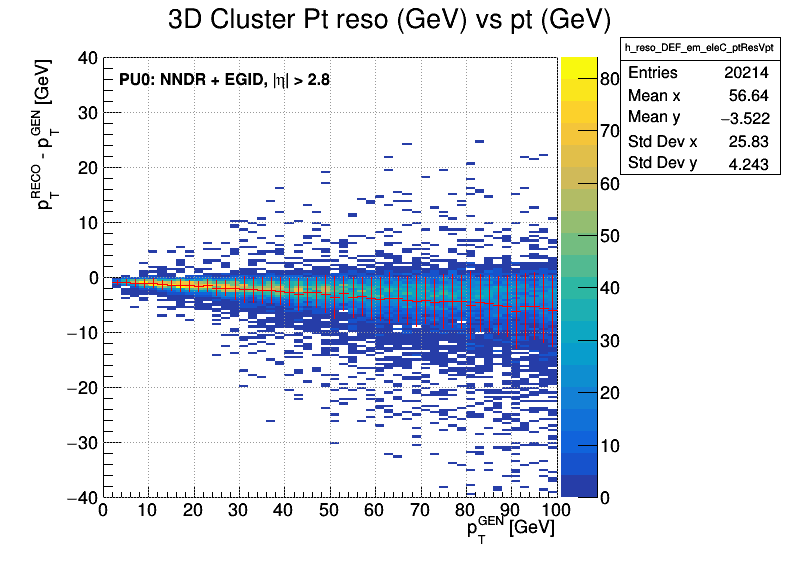

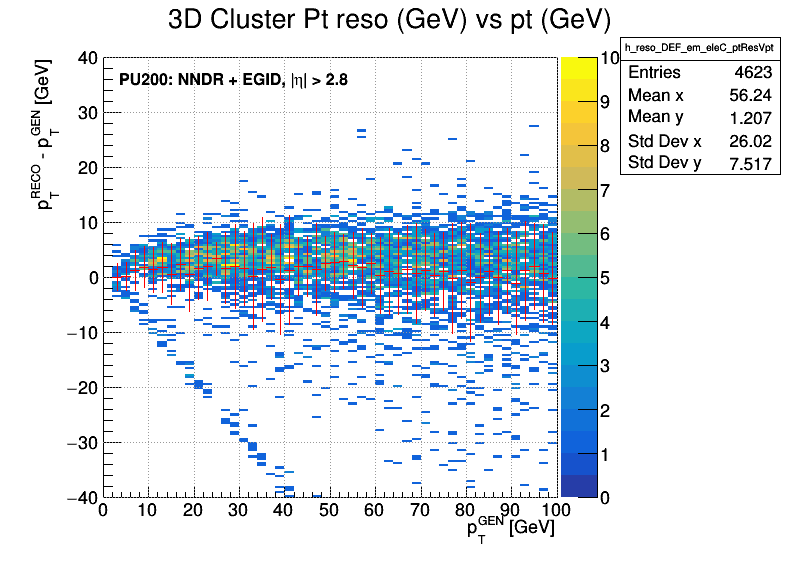

In [8]:
for particle in particles:
    for tp_set in ['DEF', 'DEF_em']:
        hByTPset = [histo.h_ptResVpt for histo in histo_reso_df.loc[tp_set, particle]]
        drawSeveral(hByTPset, labels, 'COLZ', do_profile=True, text=titles_df.loc[tp_set, particle])

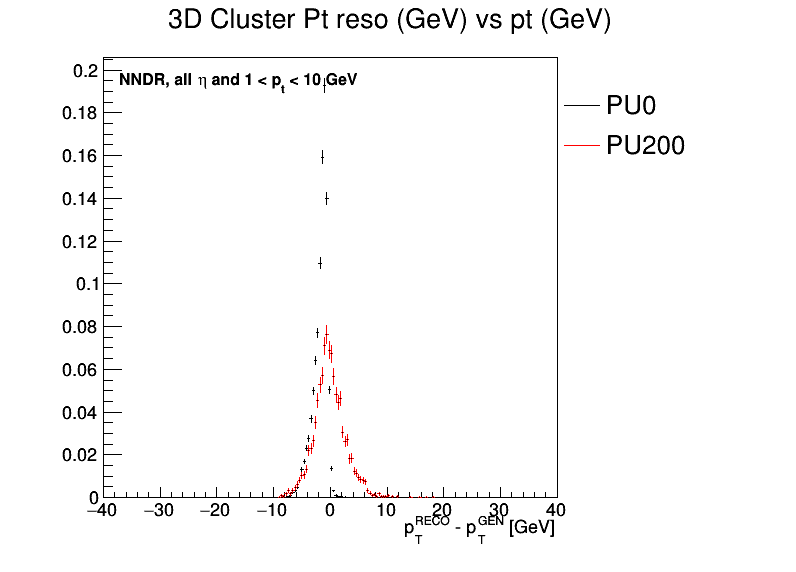

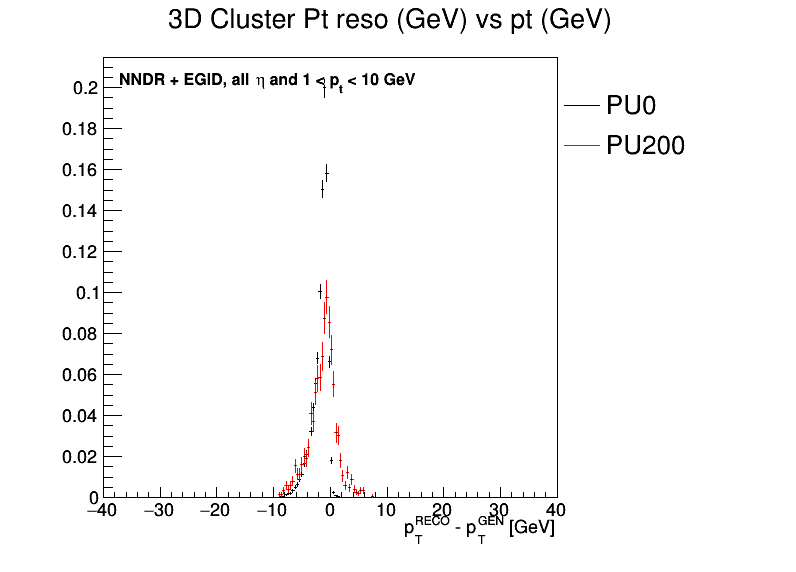

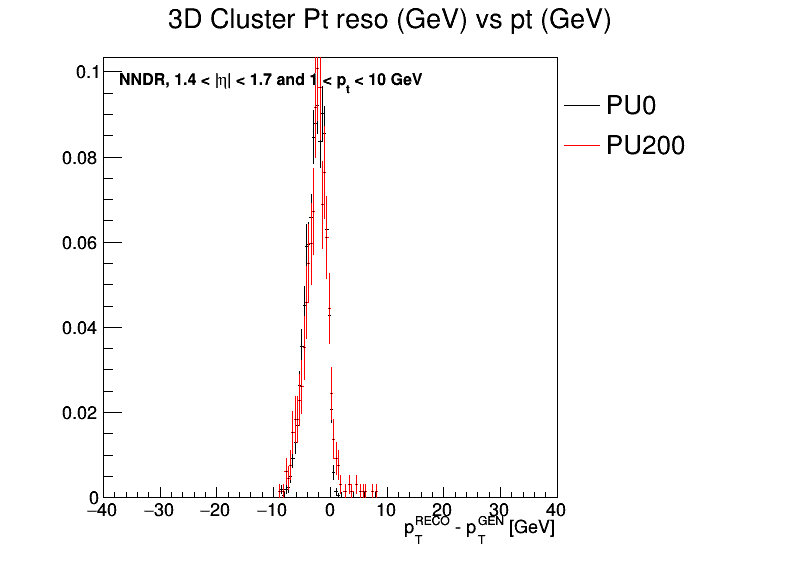

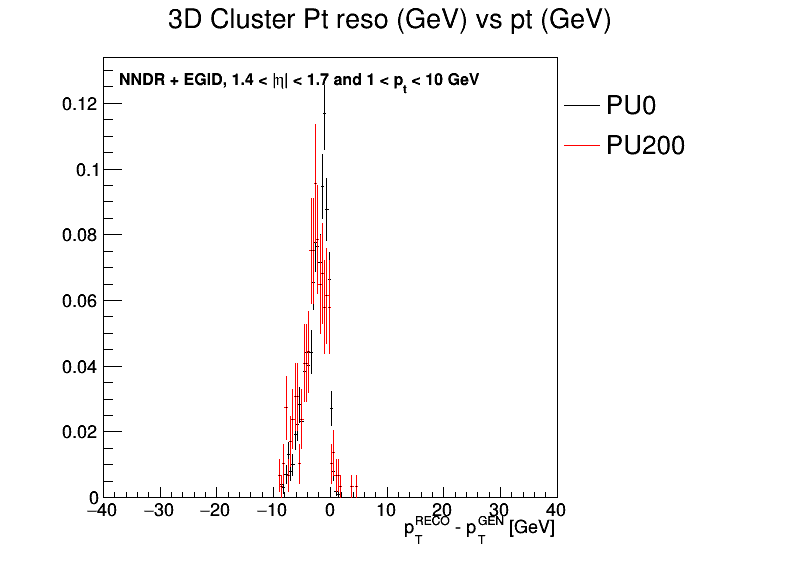

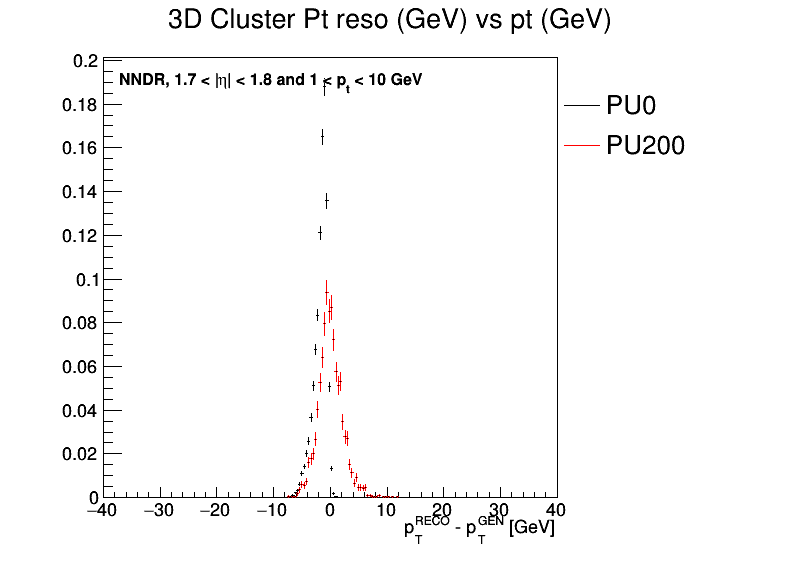

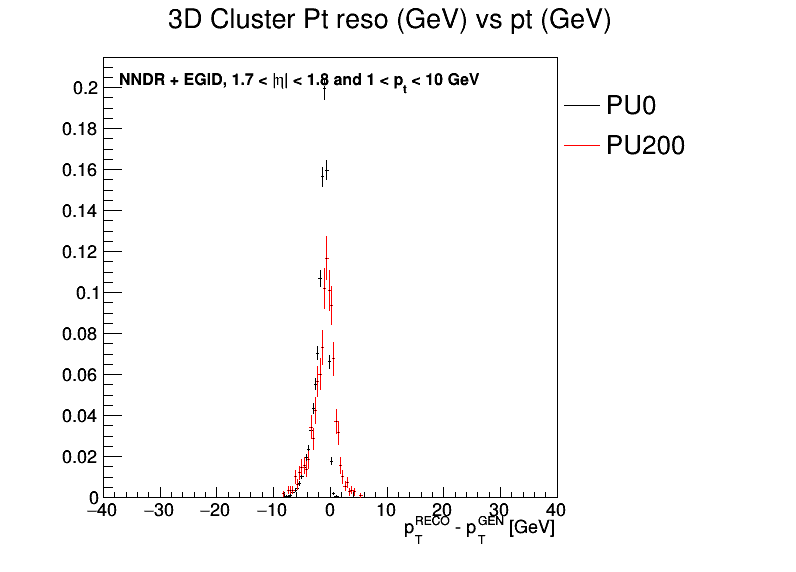

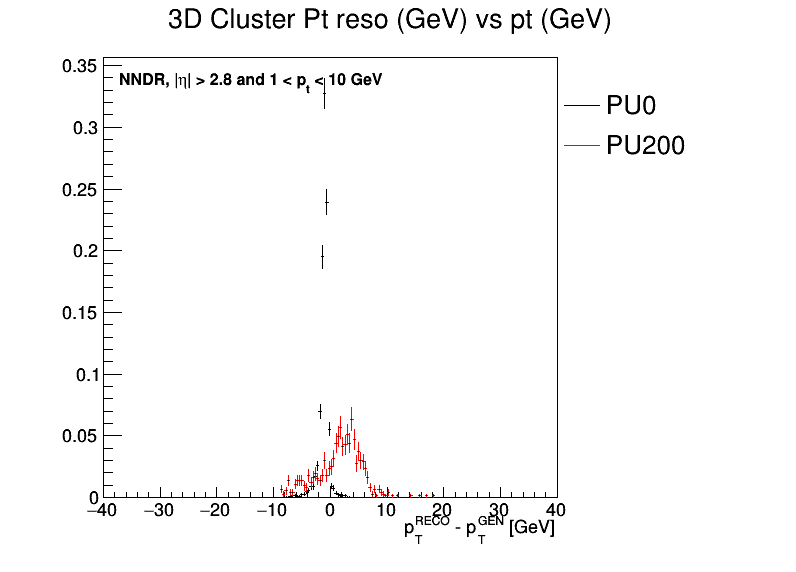

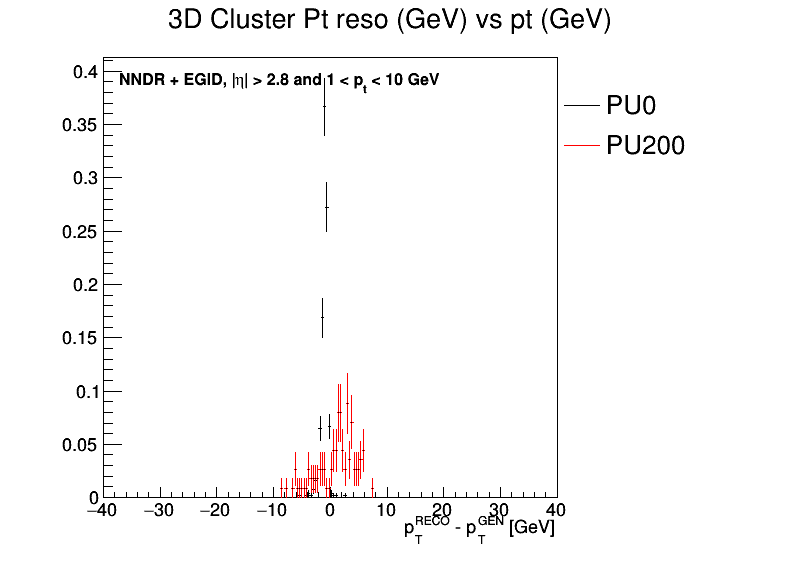

In [10]:
for particle in particles:
    for tp_set in tp_sets:
        hByTPset = [histo.h_ptResVpt.ProjectionY(uuid.uuid4().hex[:6], 1, 5) for histo in histo_reso_df.loc[tp_set, particle]]
        drawSame(hByTPset, labels, norm=True, text=titles_df.loc[tp_set, particle]+' and 1 < p_{t} < 10 GeV')


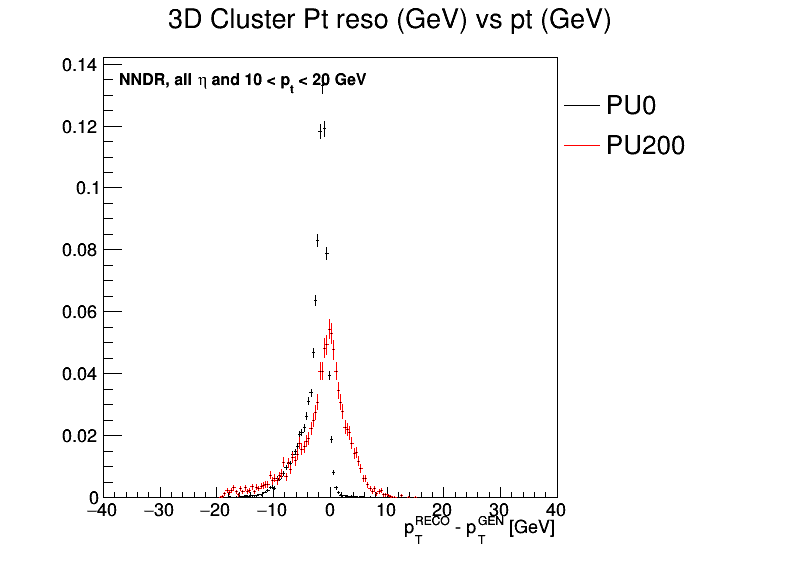

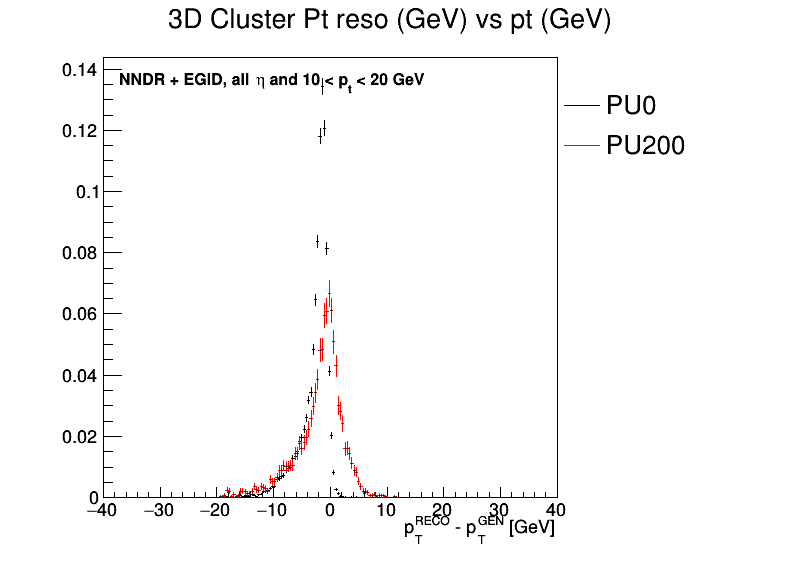

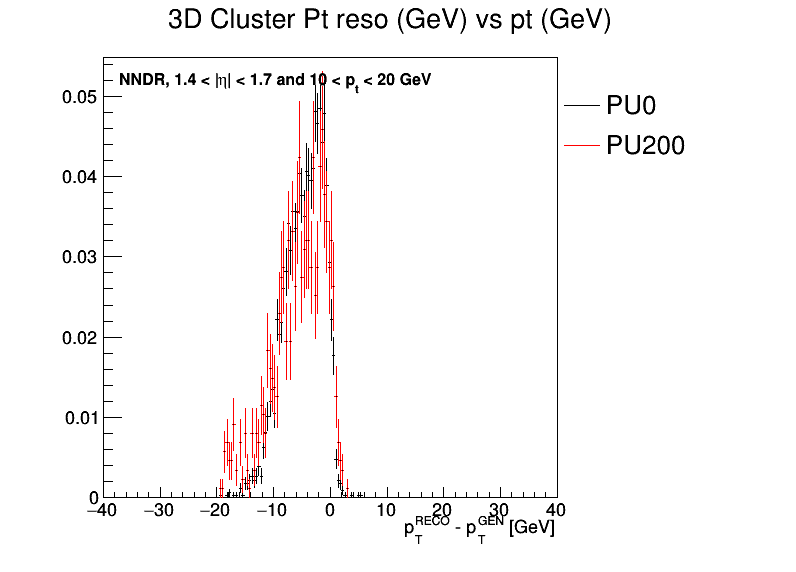

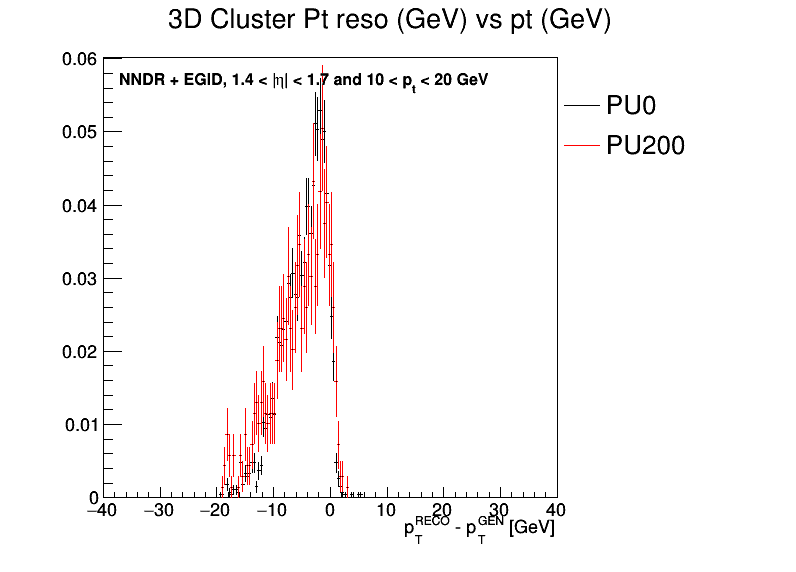

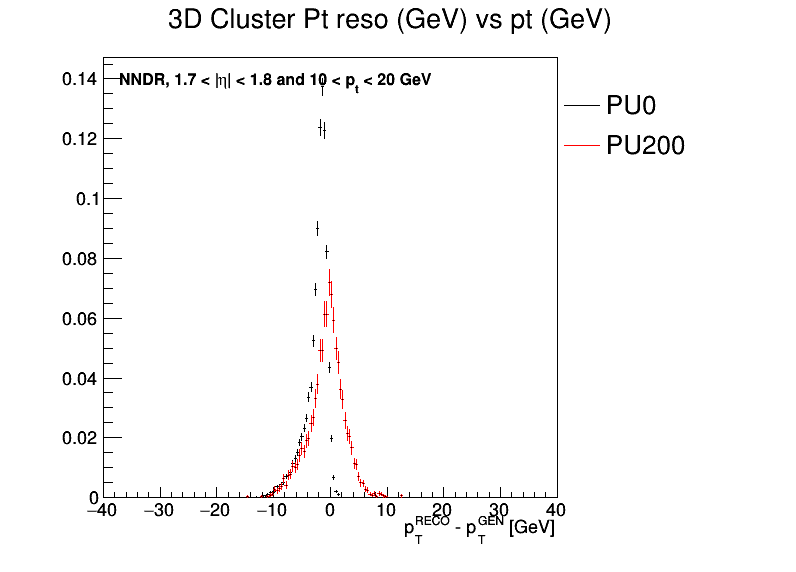

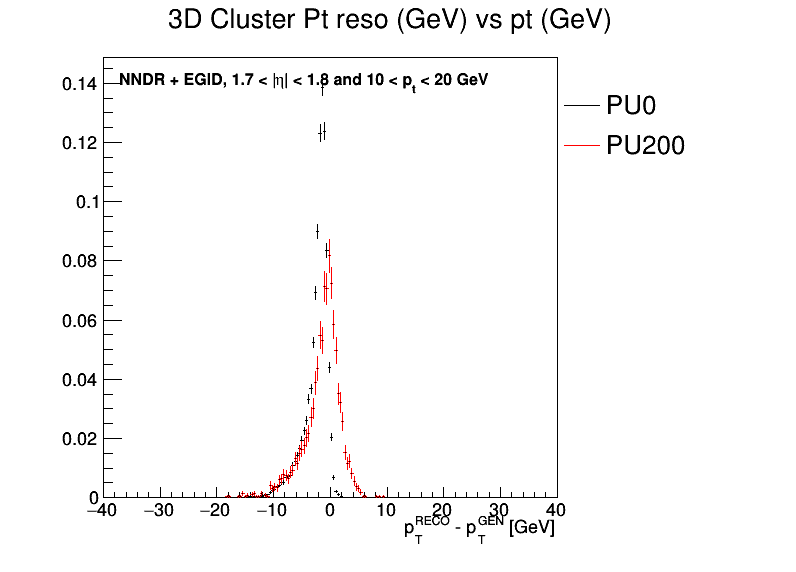

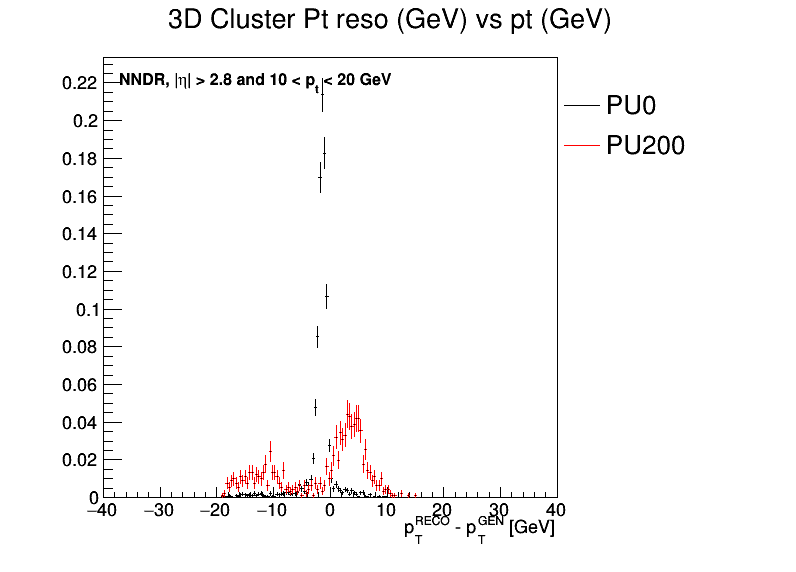

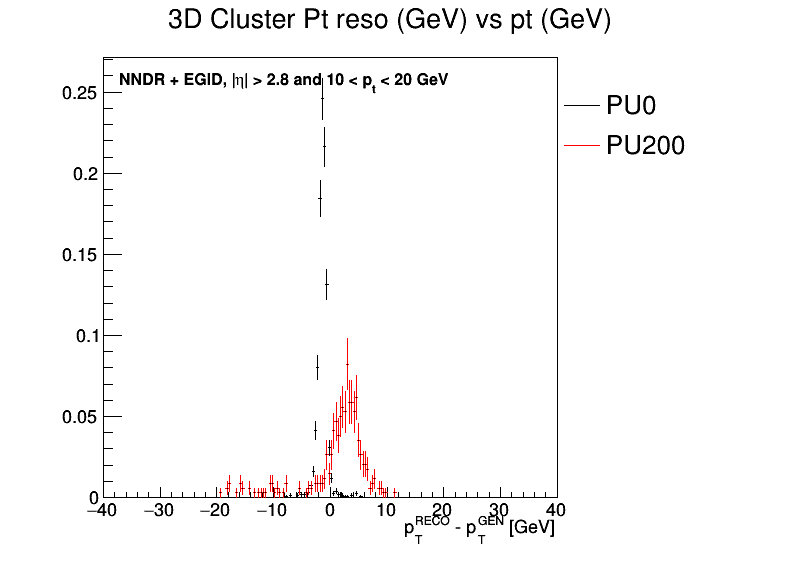

In [11]:
for particle in particles:
    for tp_set in tp_sets:
        hByTPset = [histo.h_ptResVpt.ProjectionY(uuid.uuid4().hex[:6], 6, 10) for histo in histo_reso_df.loc[tp_set, particle]]
        drawSame(hByTPset, labels, norm=True, text=titles_df.loc[tp_set, particle]+' and 10 < p_{t} < 20 GeV')


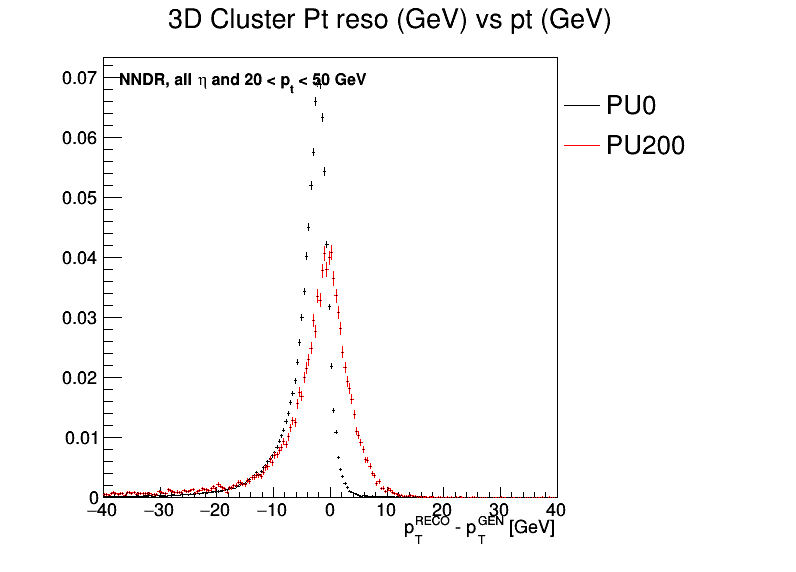

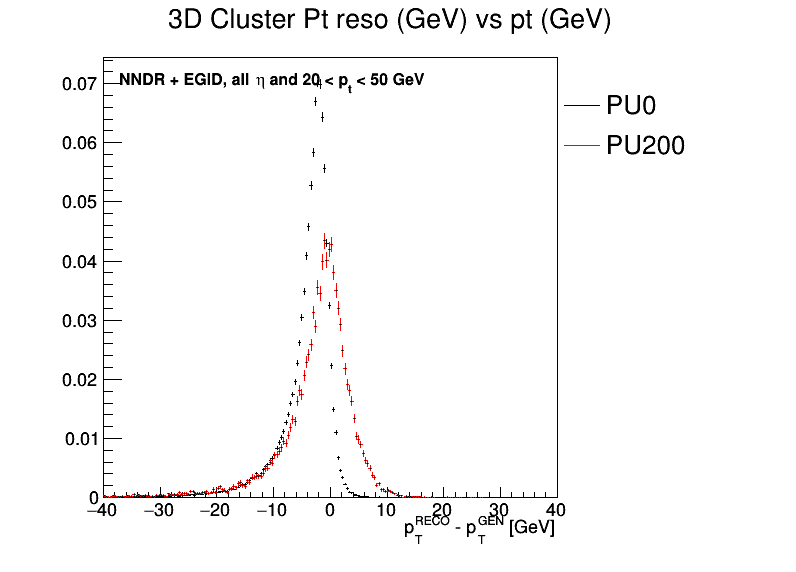

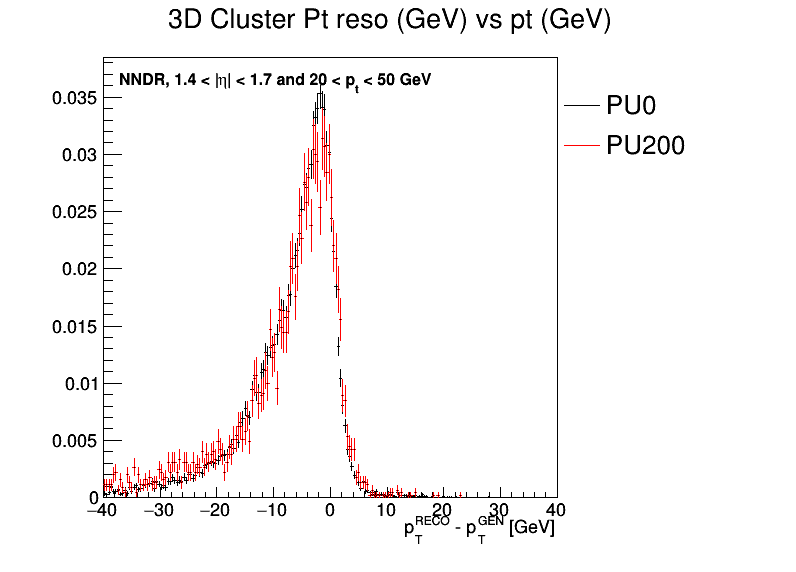

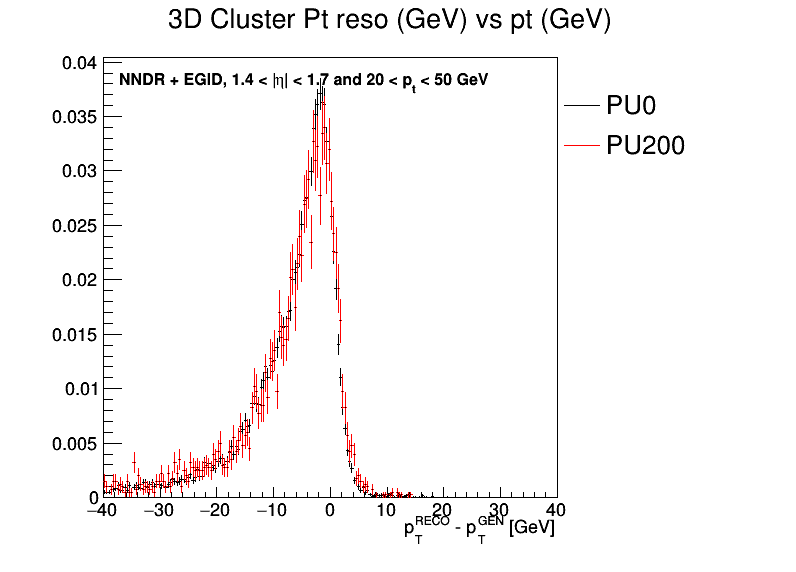

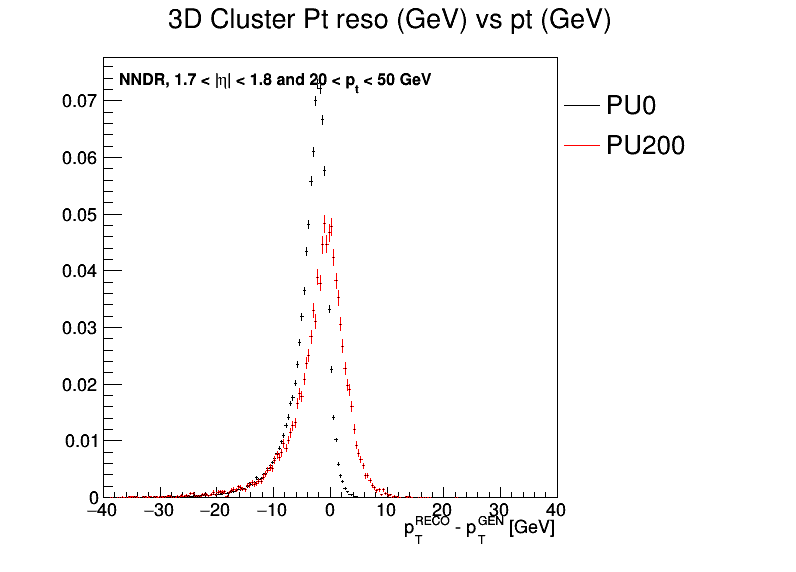

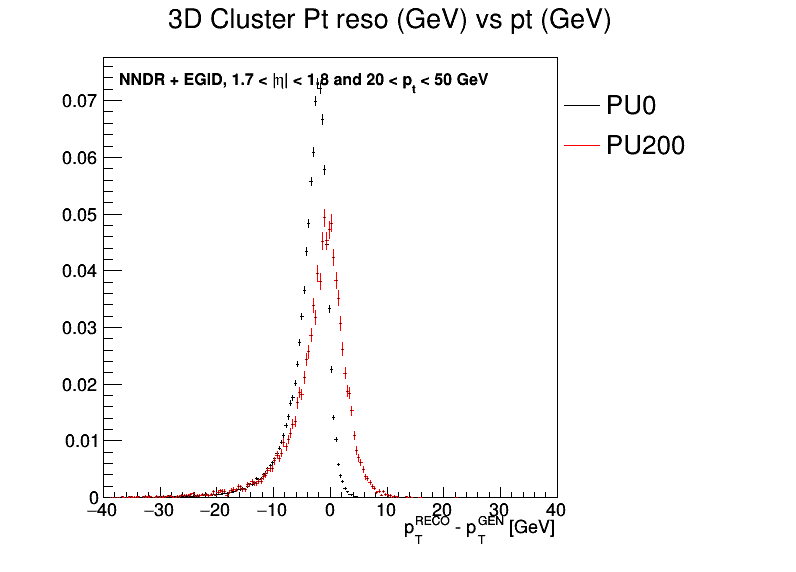

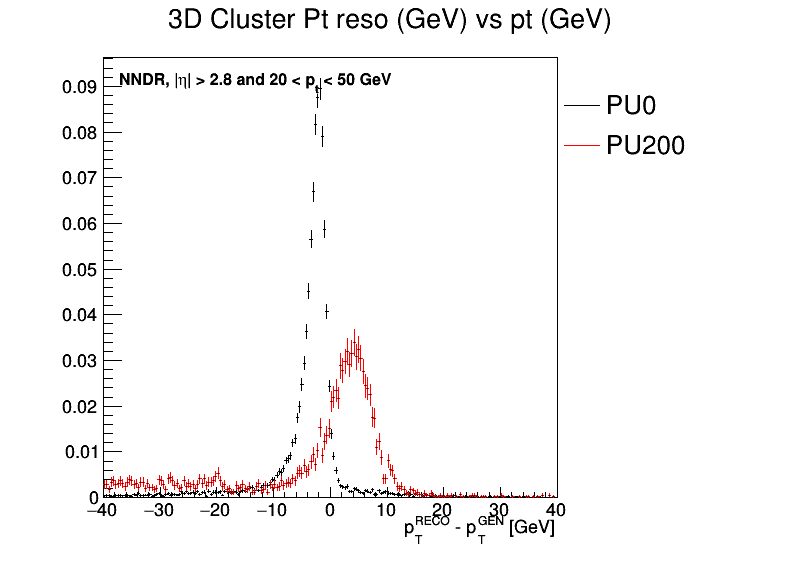

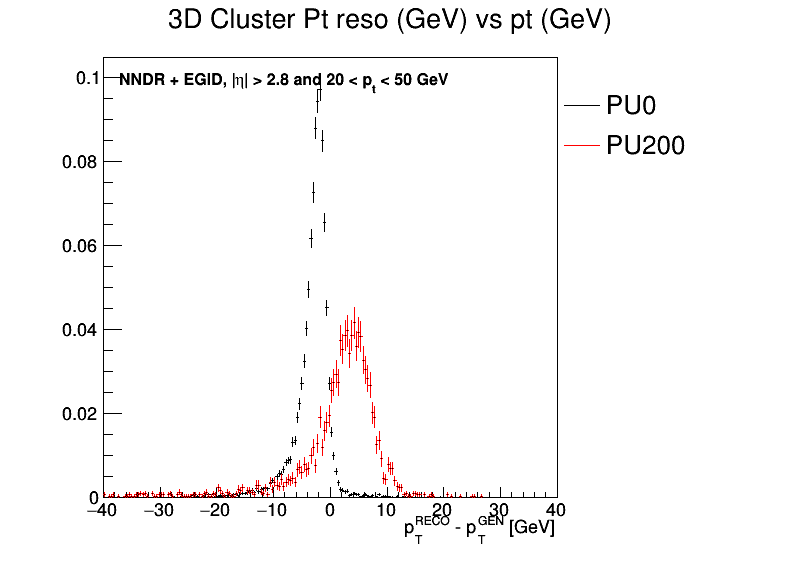

In [12]:
for particle in particles:
    for tp_set in tp_sets:
        hByTPset = [histo.h_ptResVpt.ProjectionY(uuid.uuid4().hex[:6], 11, 40) for histo in histo_reso_df.loc[tp_set, particle]]
        drawSame(hByTPset, labels, norm=True, text=titles_df.loc[tp_set, particle]+' and 20 < p_{t} < 50 GeV')


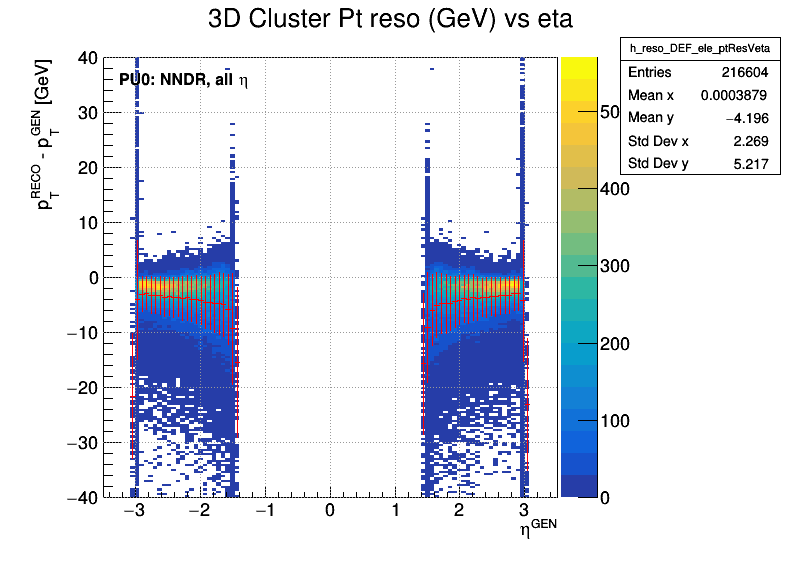

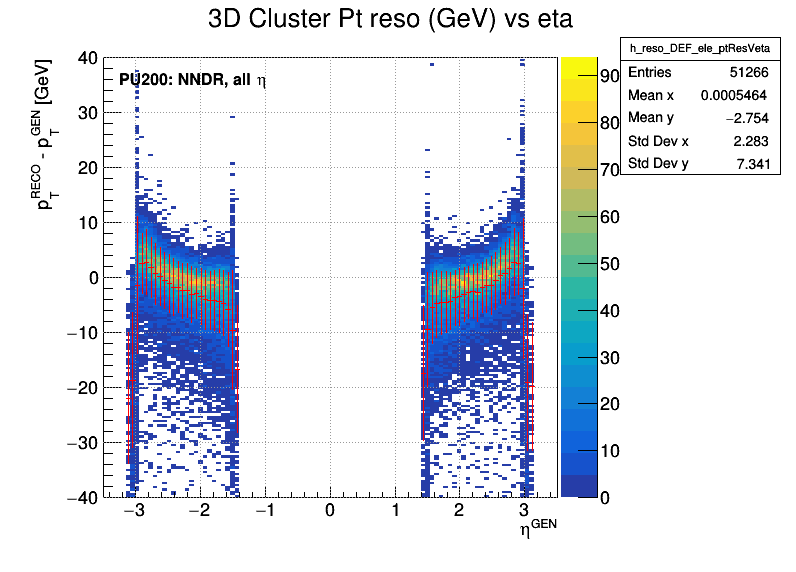

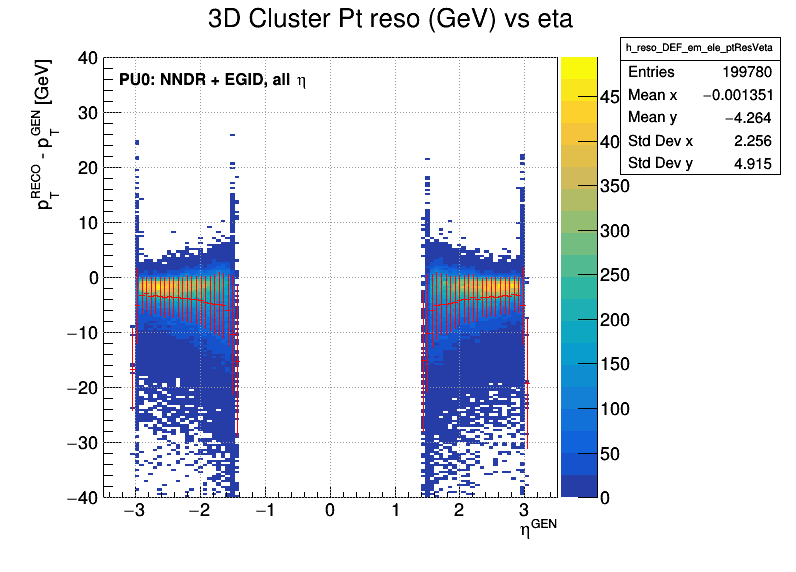

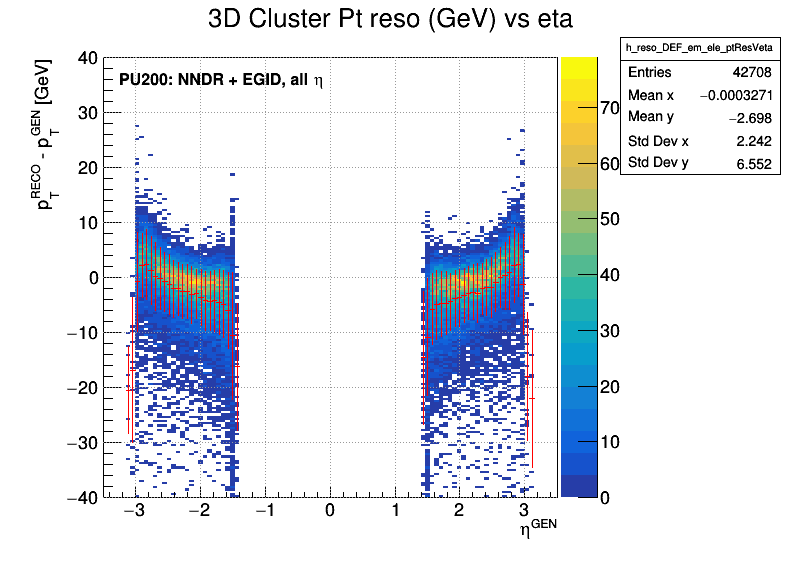

In [14]:
for particle in ['ele']:
    for tp_set in ['DEF', 'DEF_em']:
        hByTPset = [histo.h_ptResVeta for histo in histo_reso_df.loc[tp_set, particle]]
        drawSeveral(hByTPset, labels, 'COLZ', do_profile=True, text=titles_df.loc[tp_set, particle])

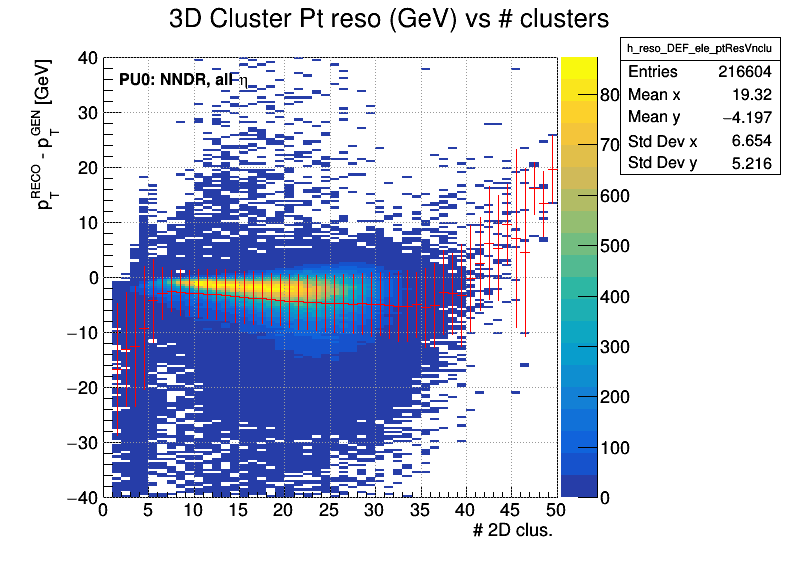

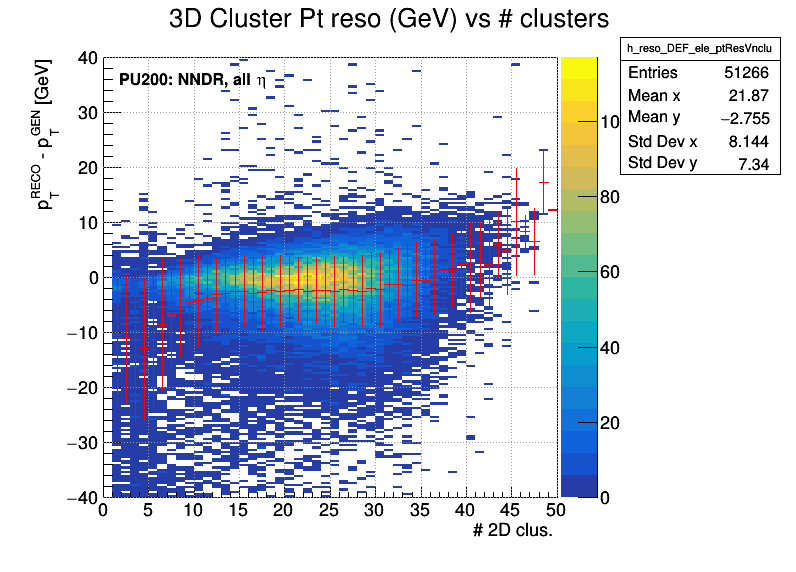

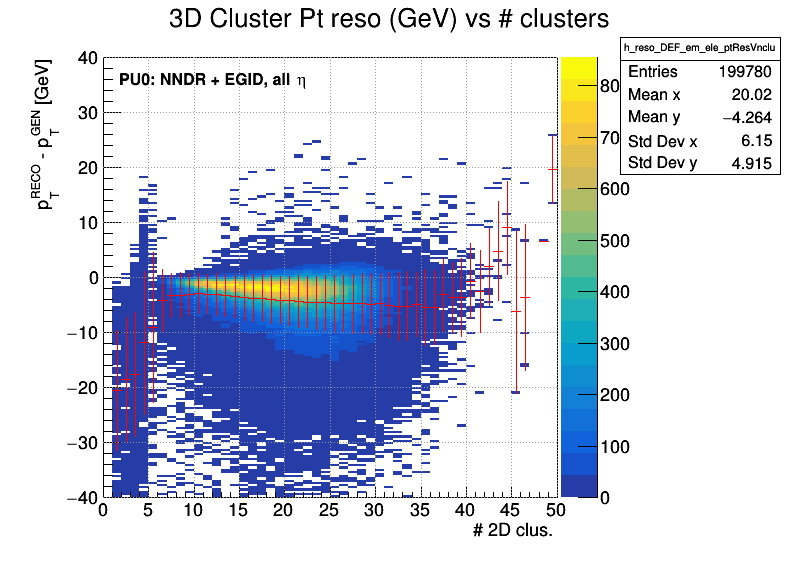

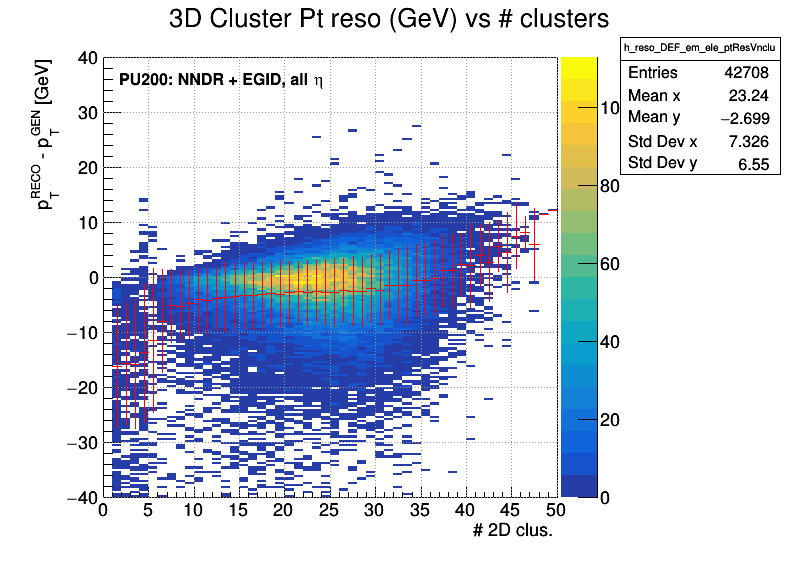

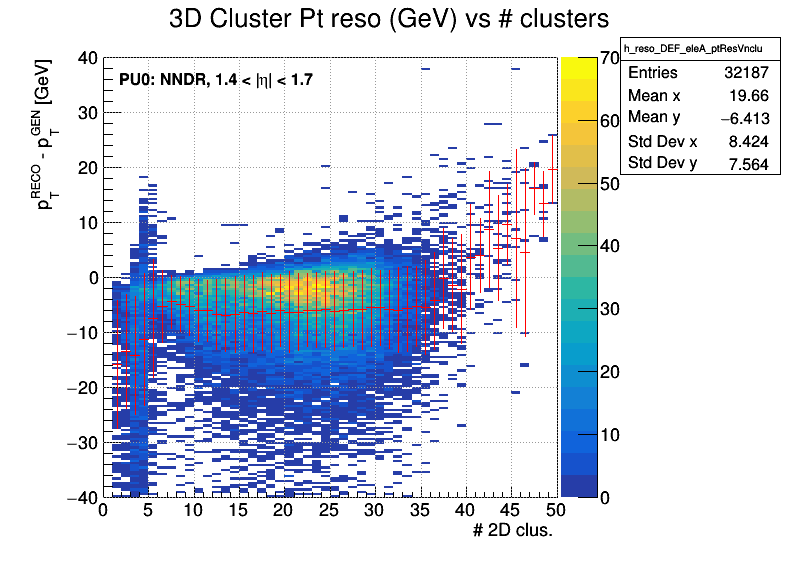

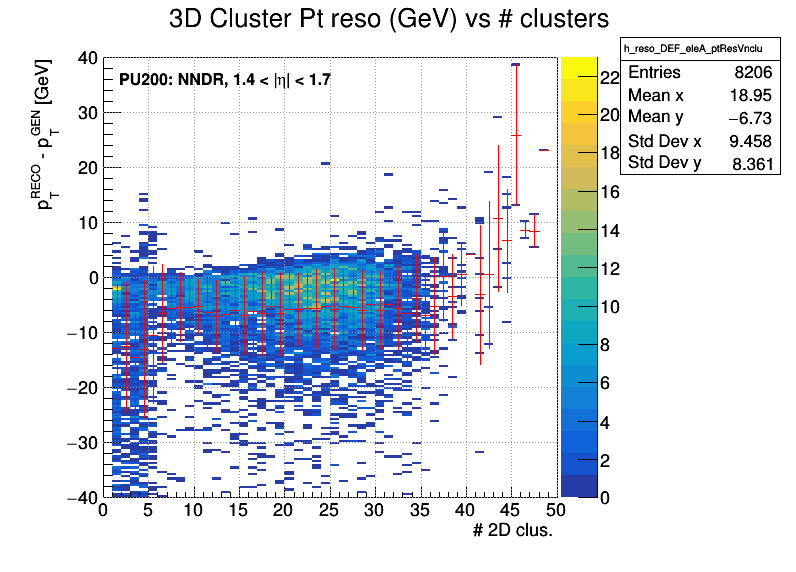

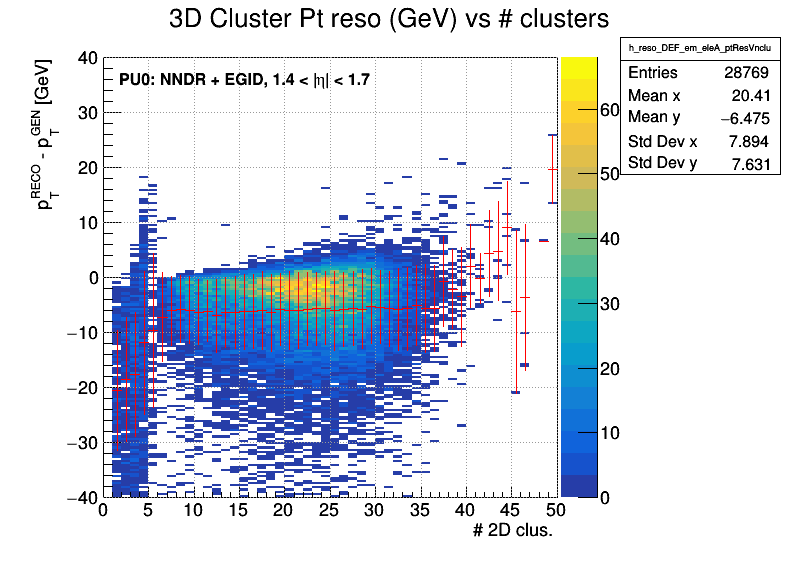

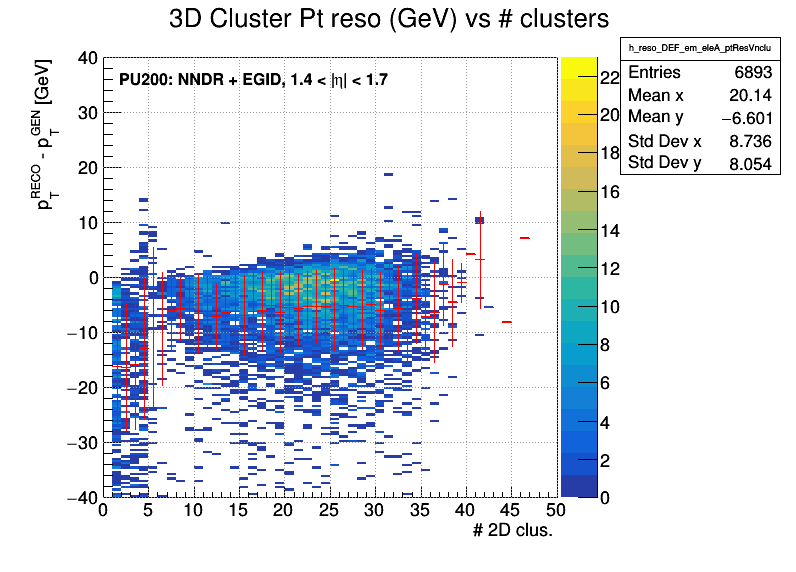

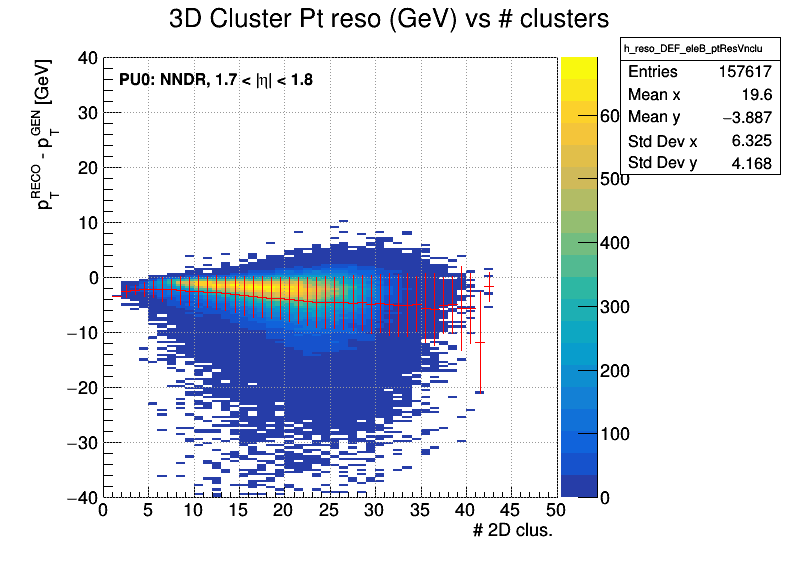

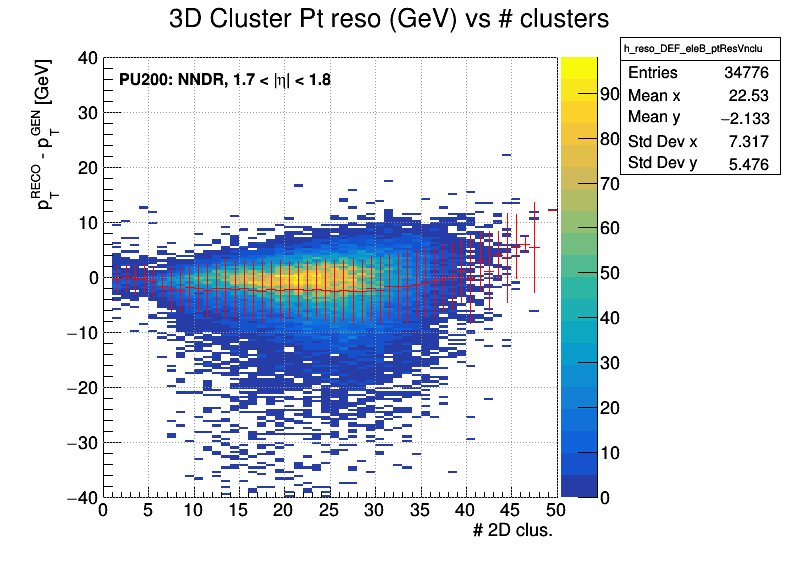

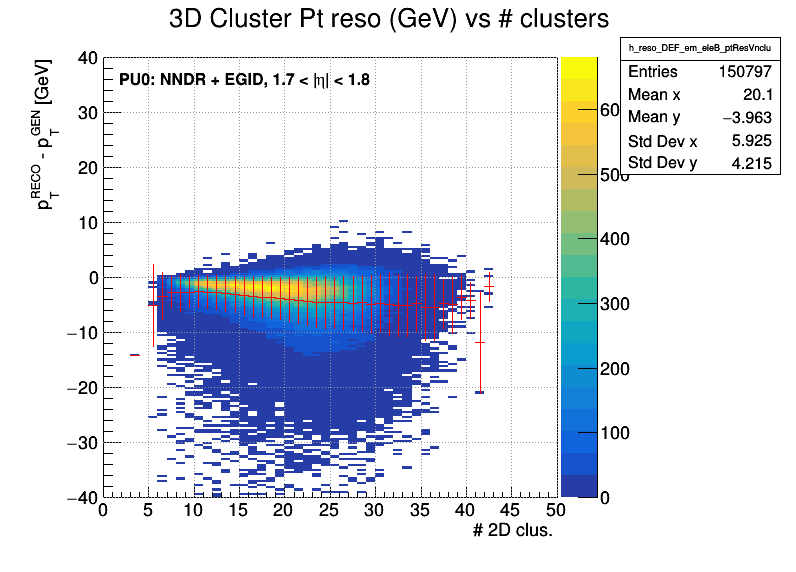

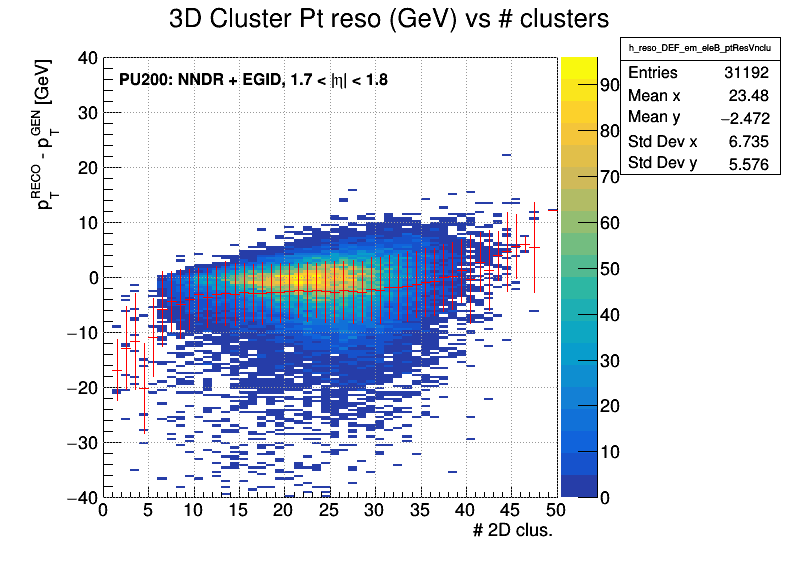

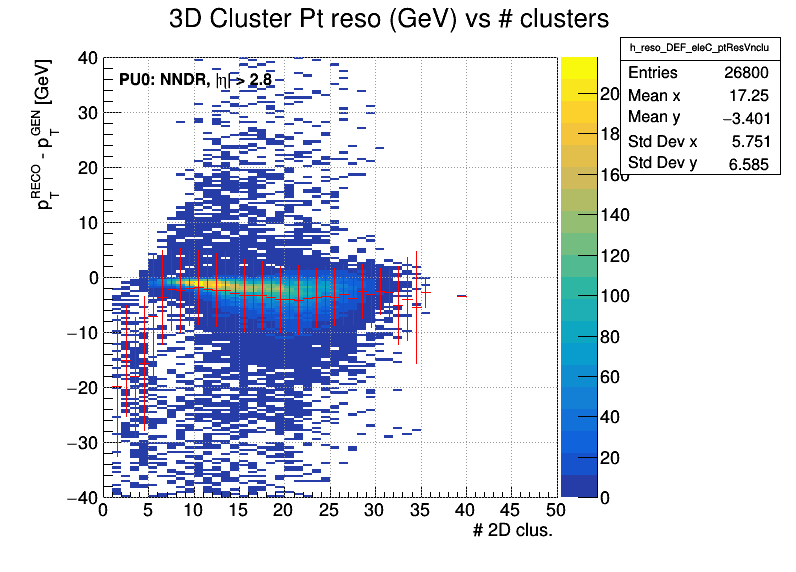

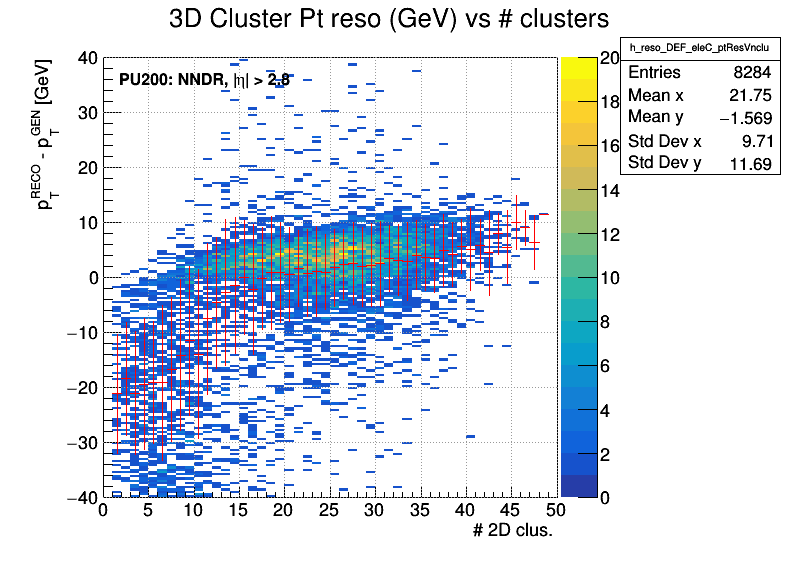

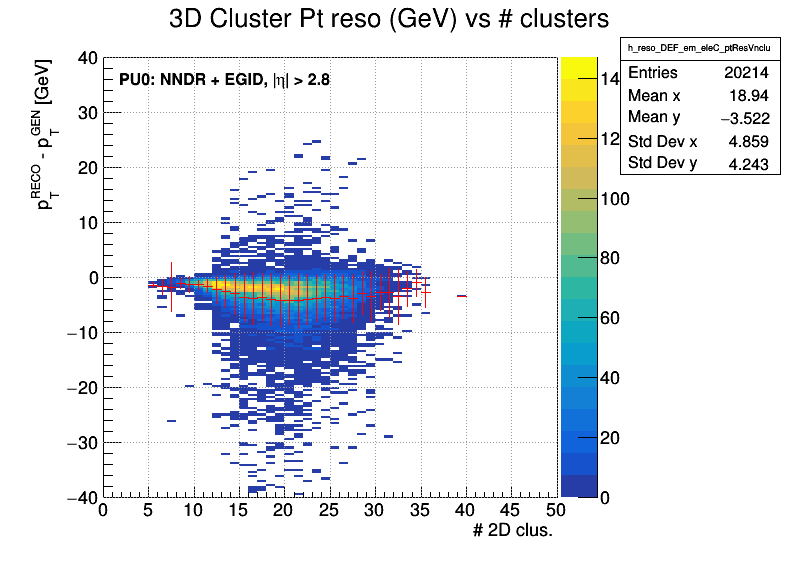

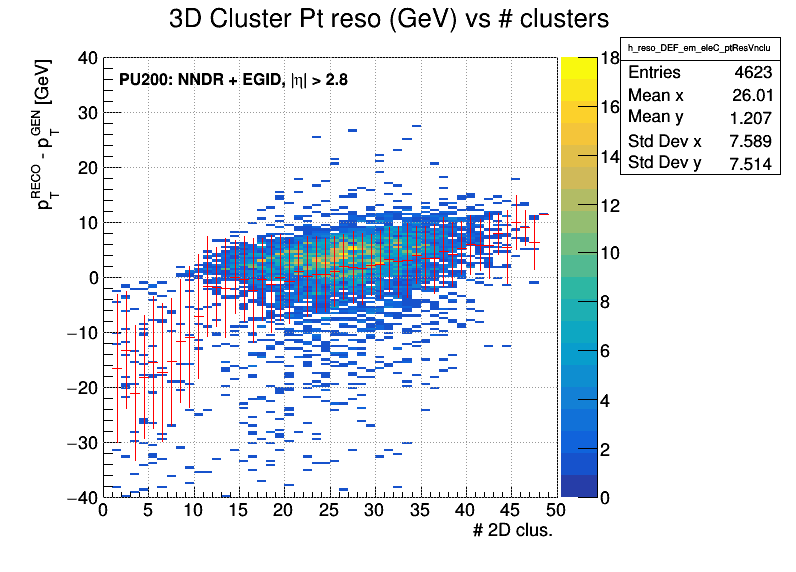

In [15]:
for particle in particles:
    for tp_set in ['DEF', 'DEF_em']:
        hByTPset = [histo.h_ptResVnclu for histo in histo_reso_df.loc[tp_set, particle]]
        drawSeveral(hByTPset, labels, 'COLZ', do_profile=True, text=titles_df.loc[tp_set, particle])

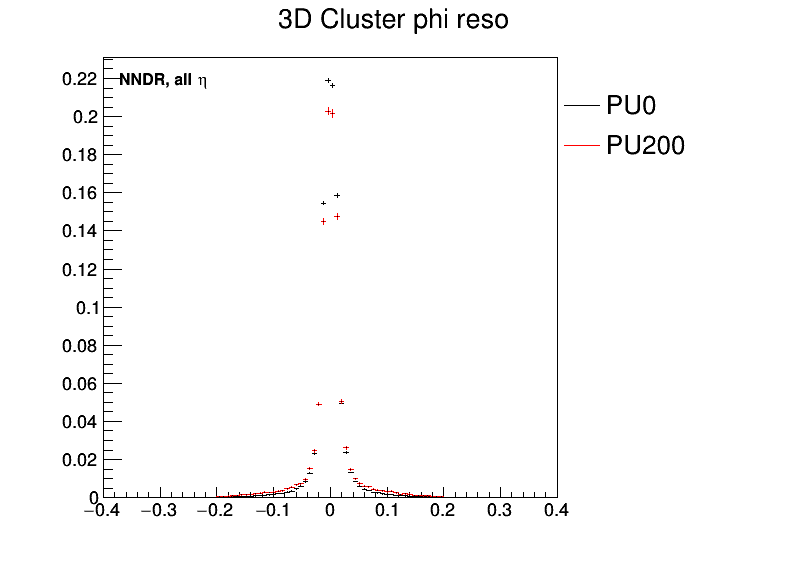

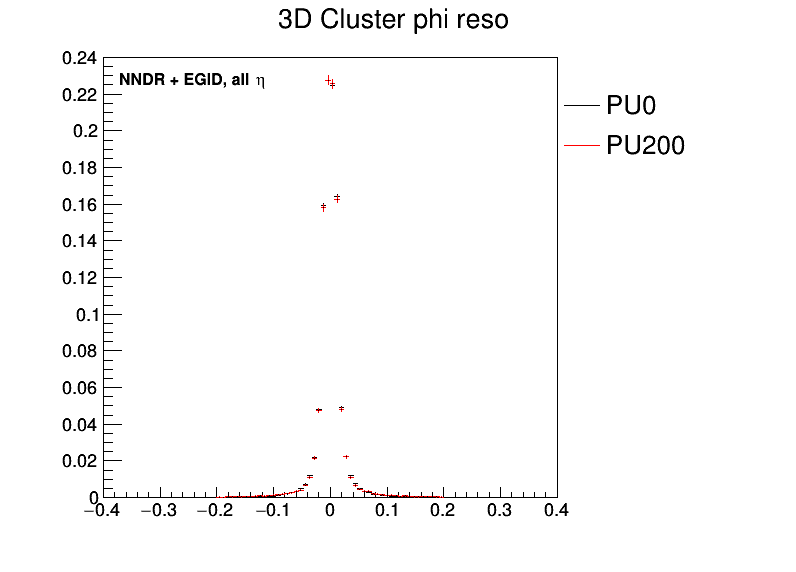

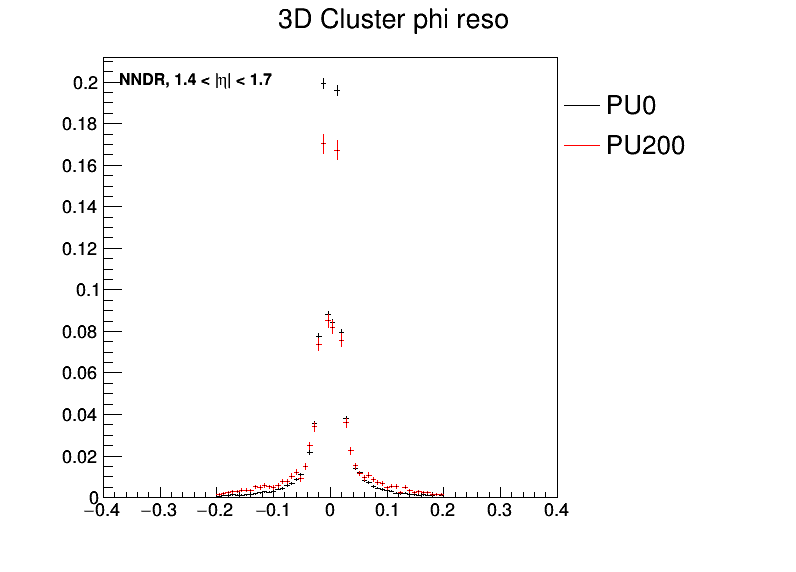

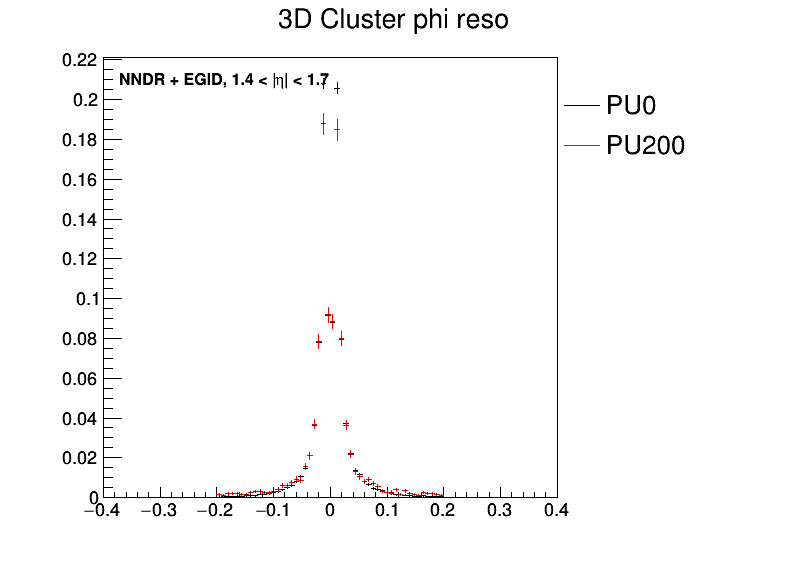

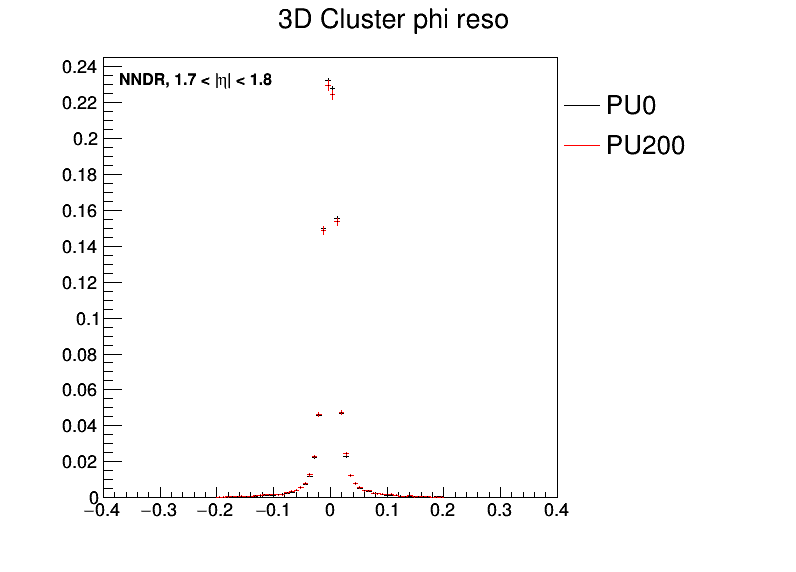

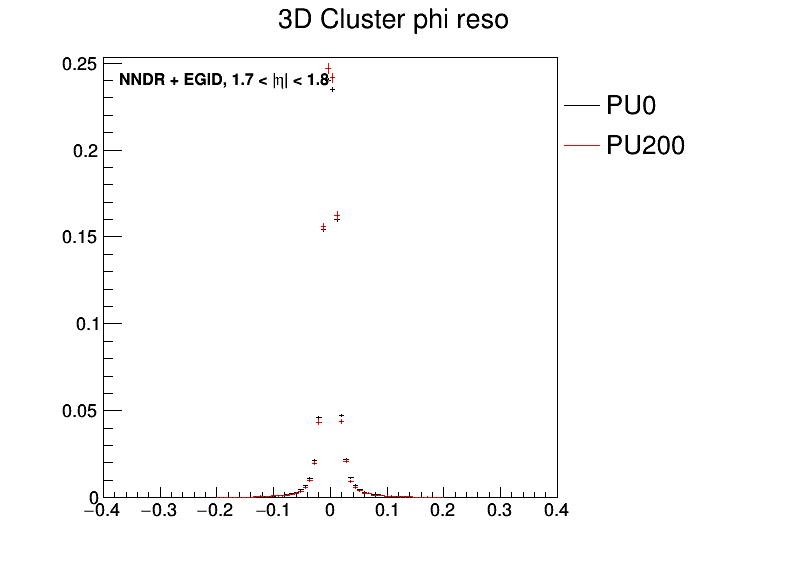

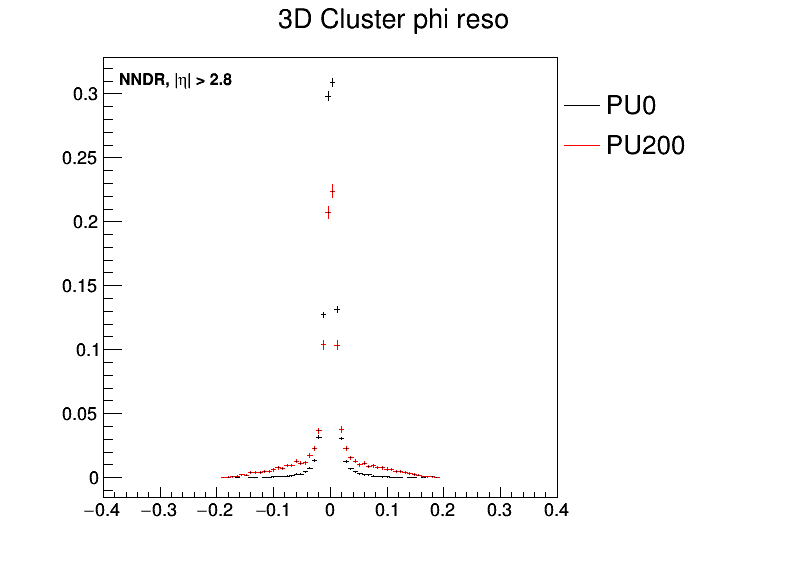

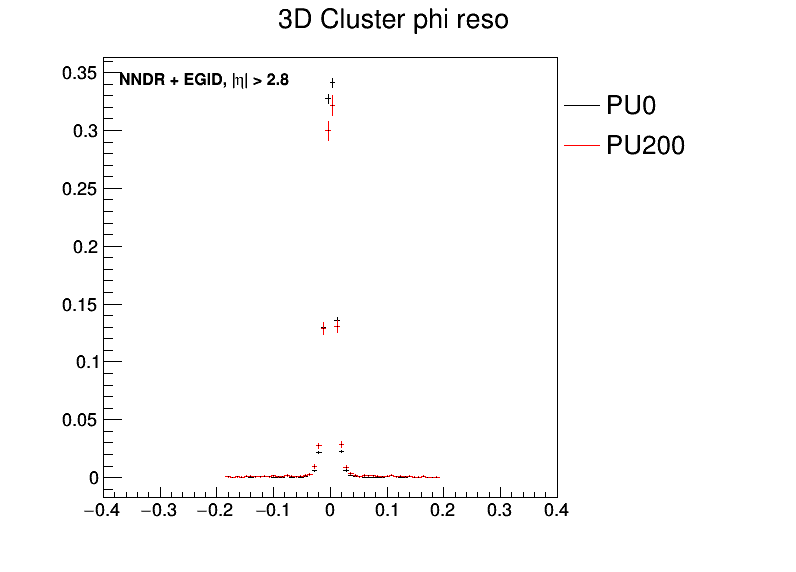

In [17]:
for particle in particles:
    for tp_set in tp_sets:
        hByTPset = [histo.h_phiRes for histo in histo_reso_df.loc[tp_set, particle]]
        drawSame(hByTPset, labels, norm=True, text=titles_df.loc[tp_set, particle])


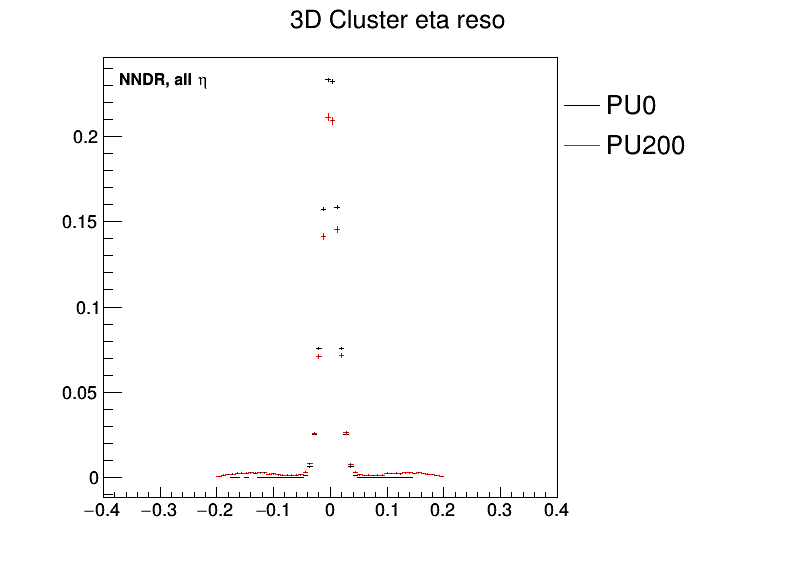

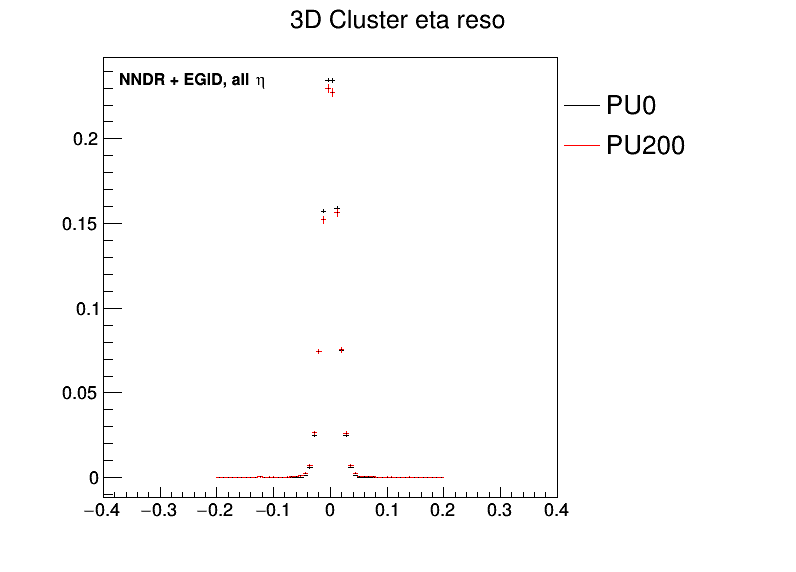

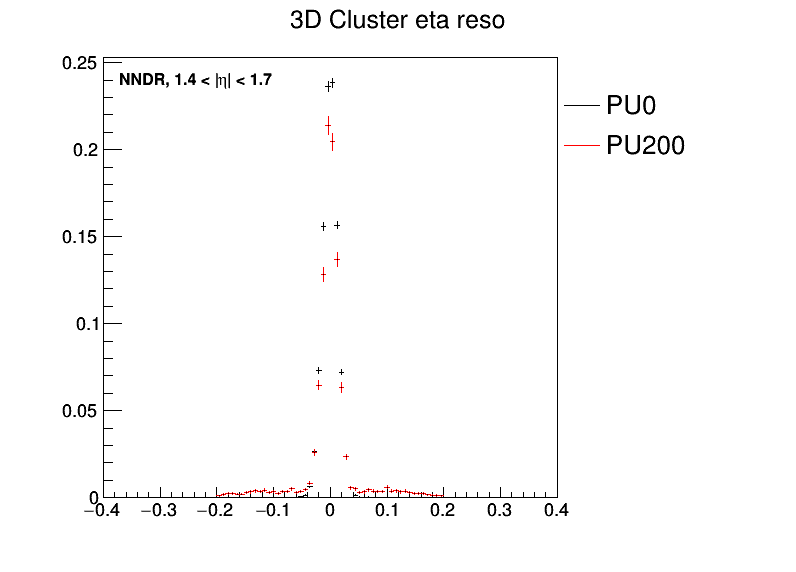

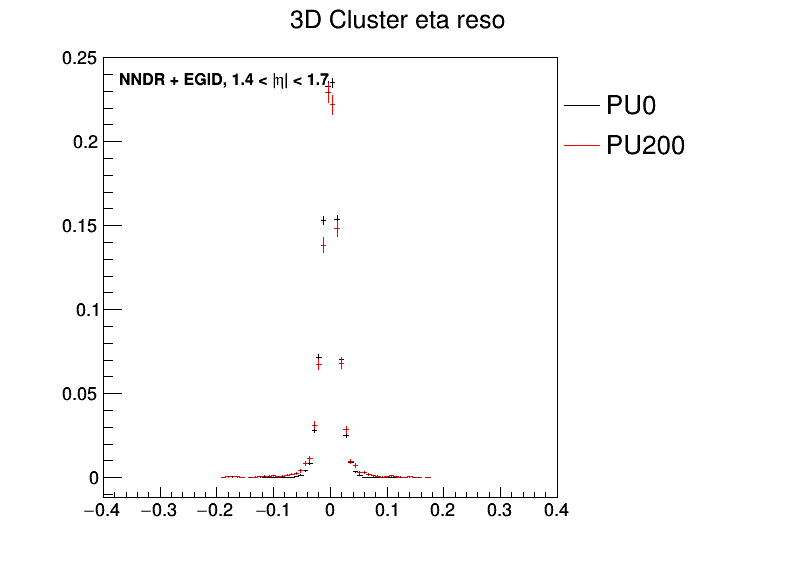

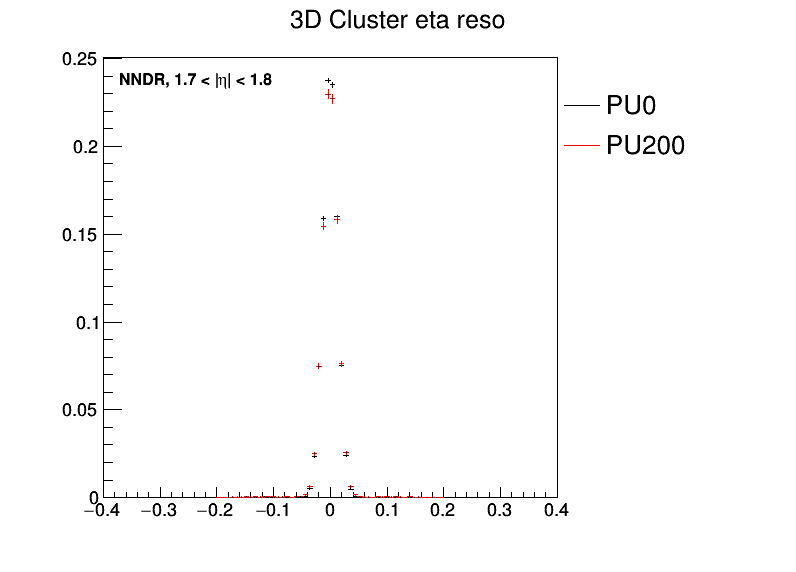

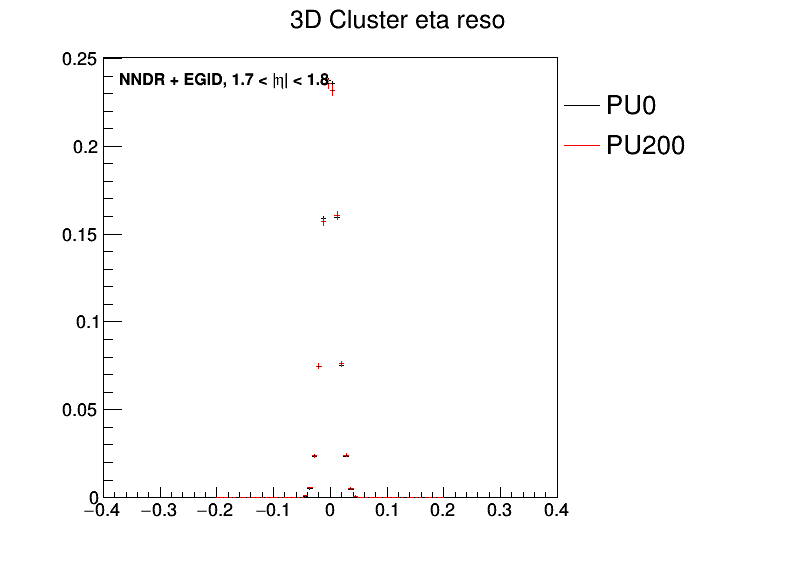

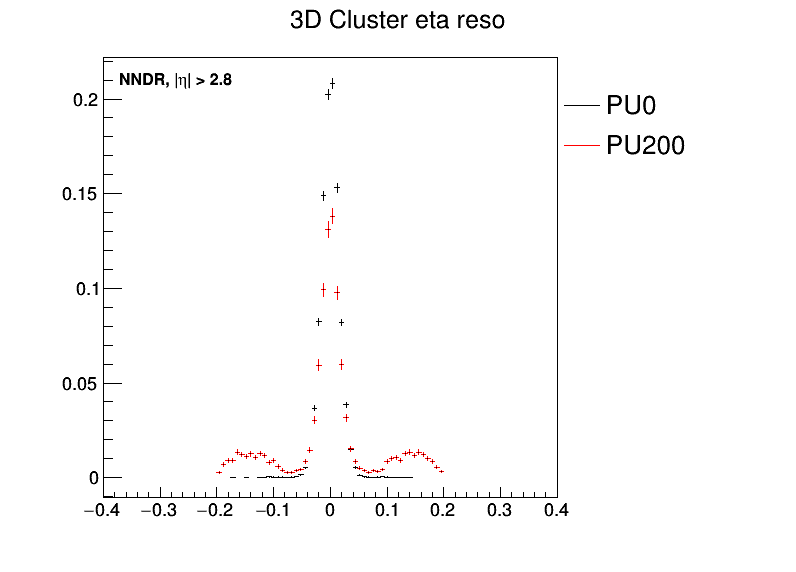

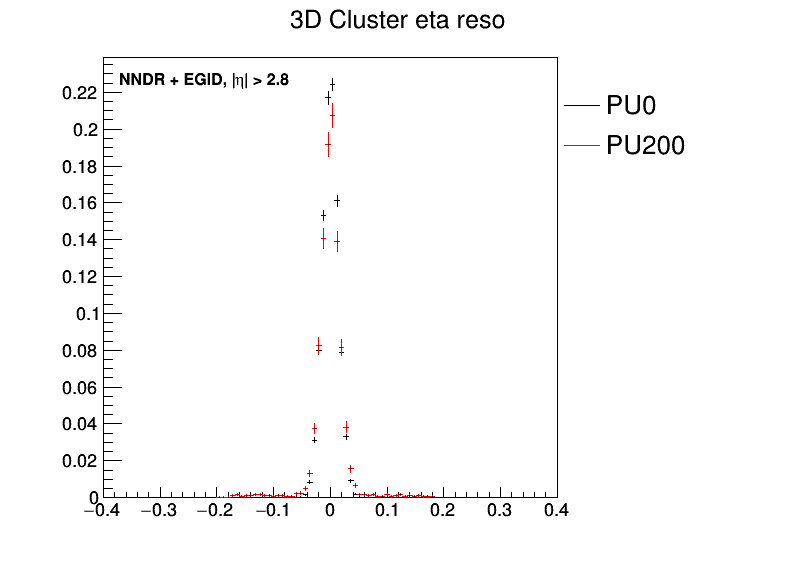

In [18]:
for particle in particles:
    for tp_set in tp_sets:
        hByTPset = [histo.h_etaRes for histo in histo_reso_df.loc[tp_set, particle]]
        drawSame(hByTPset, labels, norm=True, text=titles_df.loc[tp_set, particle])


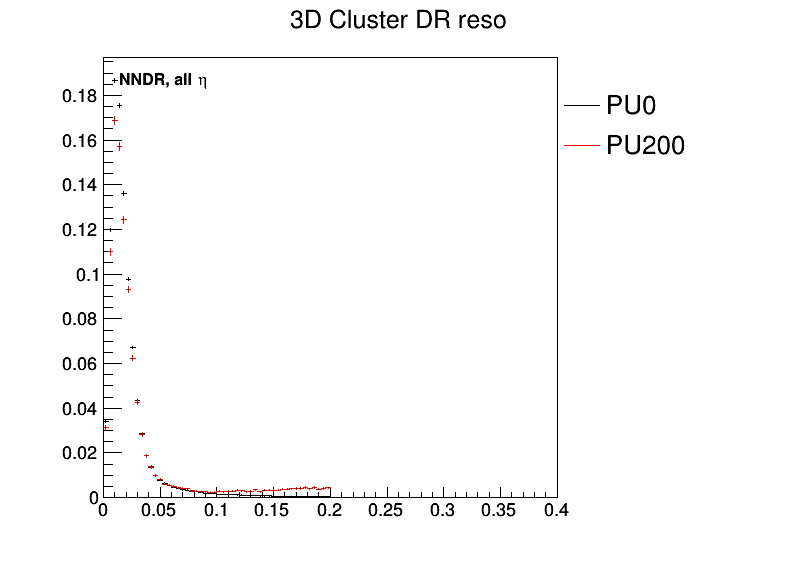

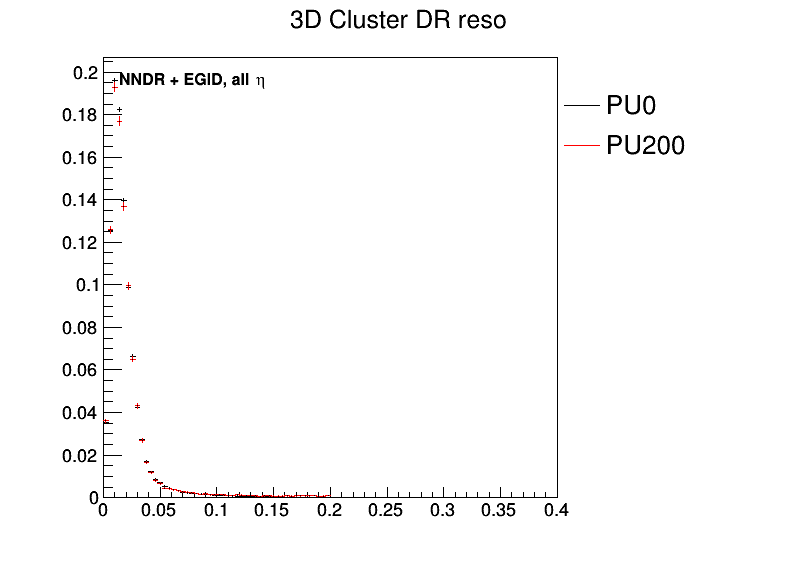

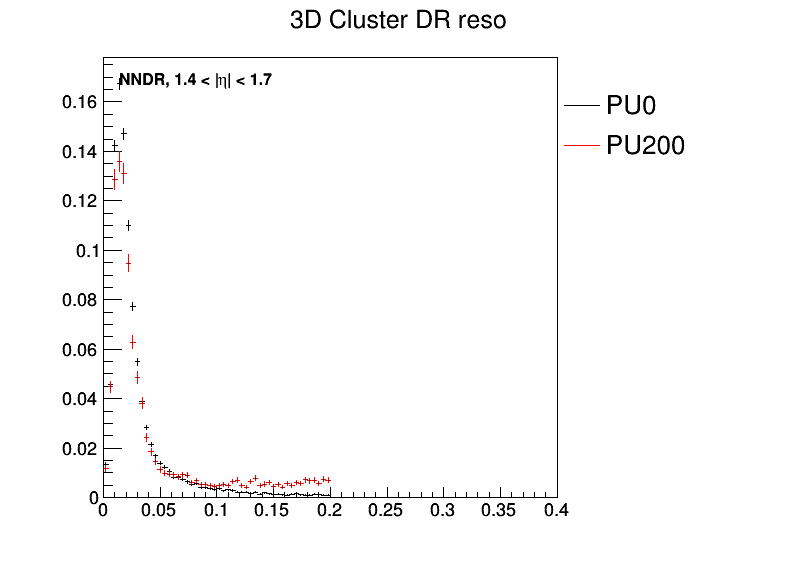

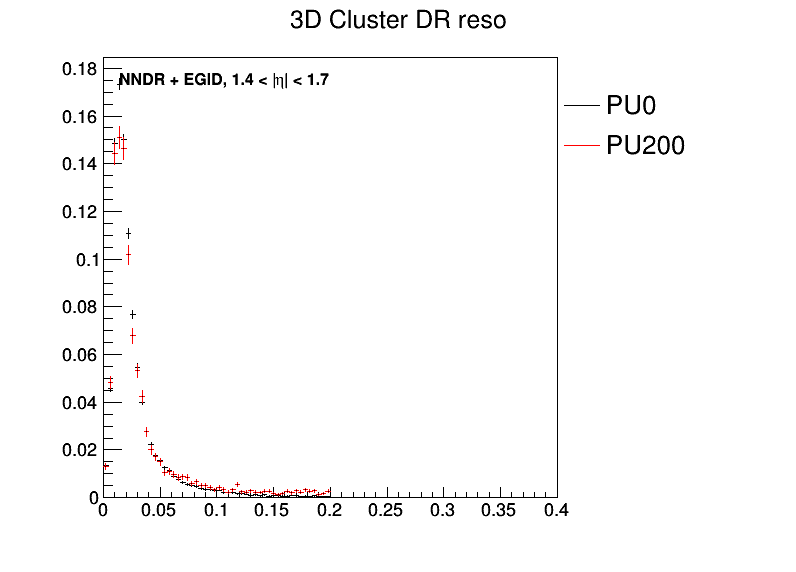

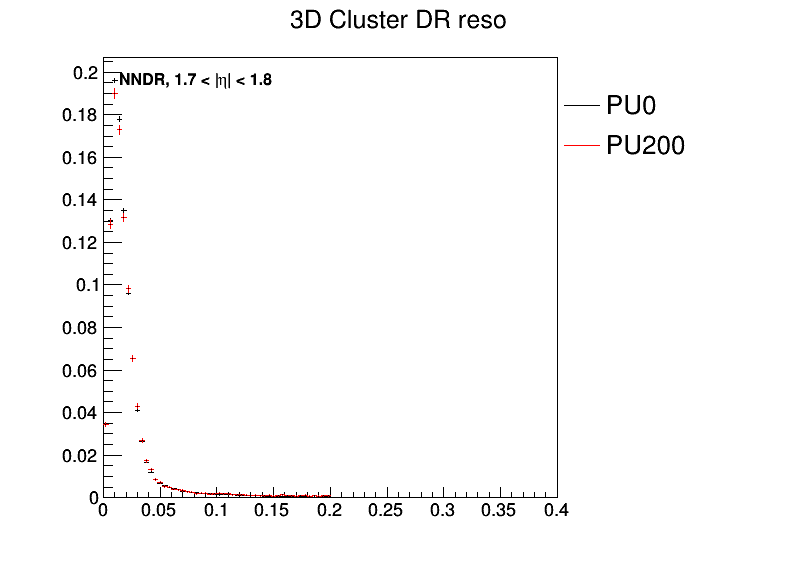

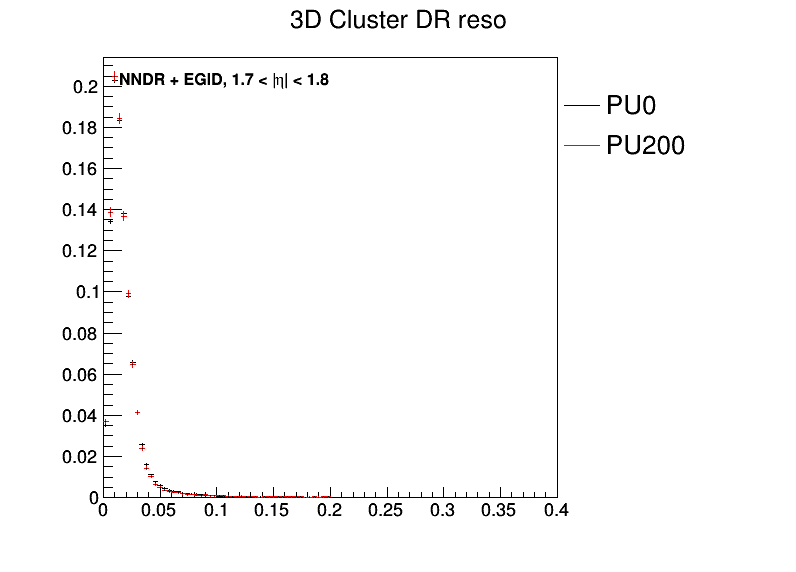

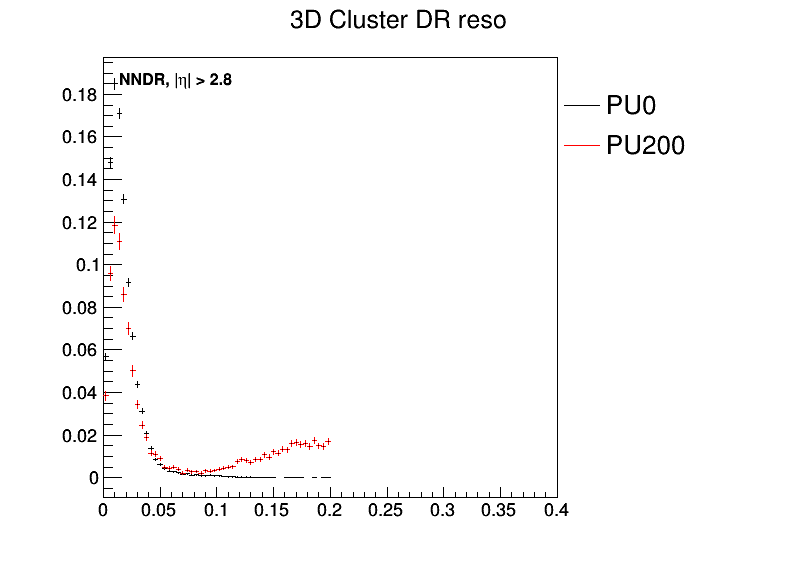

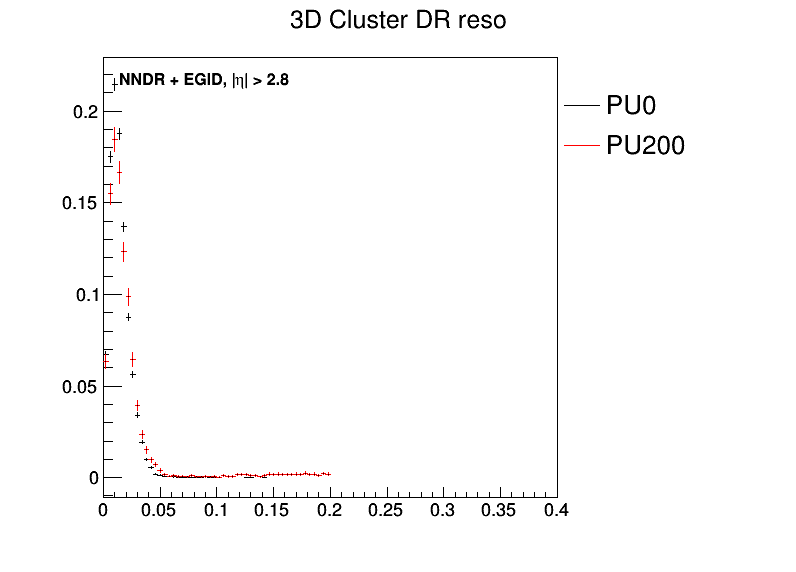

In [19]:
for particle in particles:
    for tp_set in tp_sets:
        hByTPset = [histo.h_drRes for histo in histo_reso_df.loc[tp_set, particle]]
        drawSame(hByTPset, labels, norm=True, text=titles_df.loc[tp_set, particle])


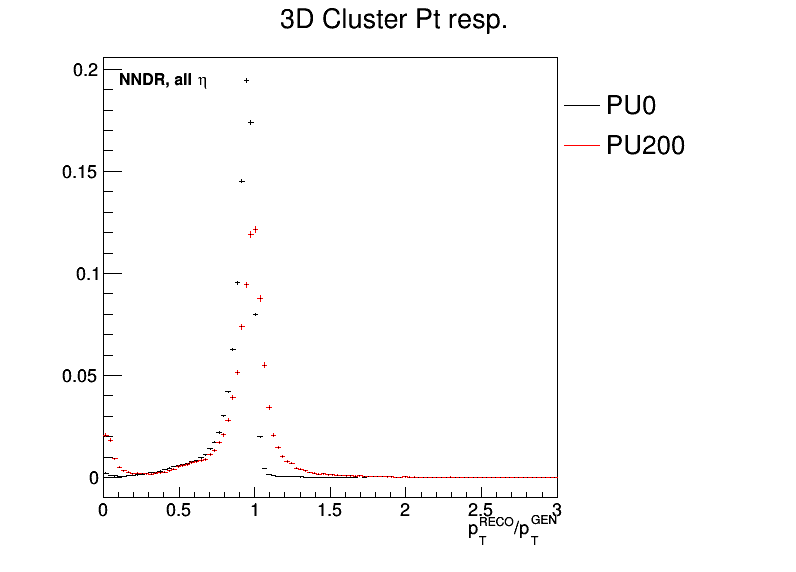

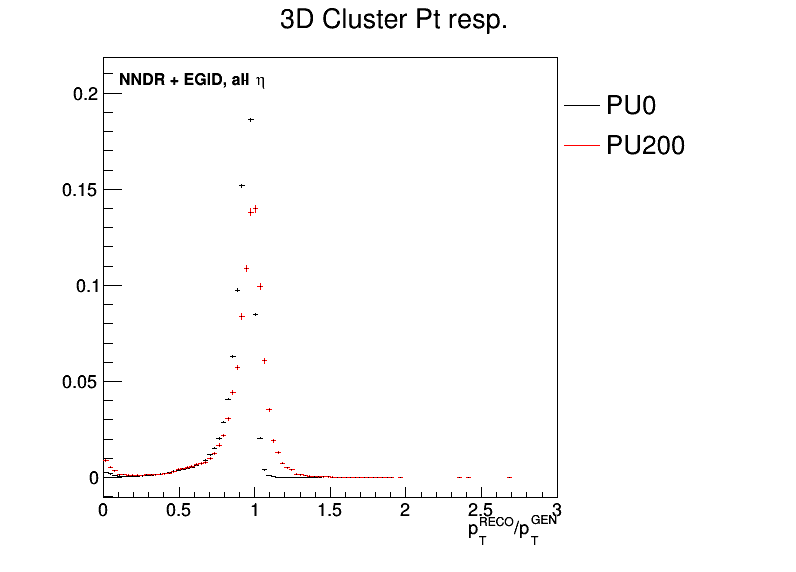

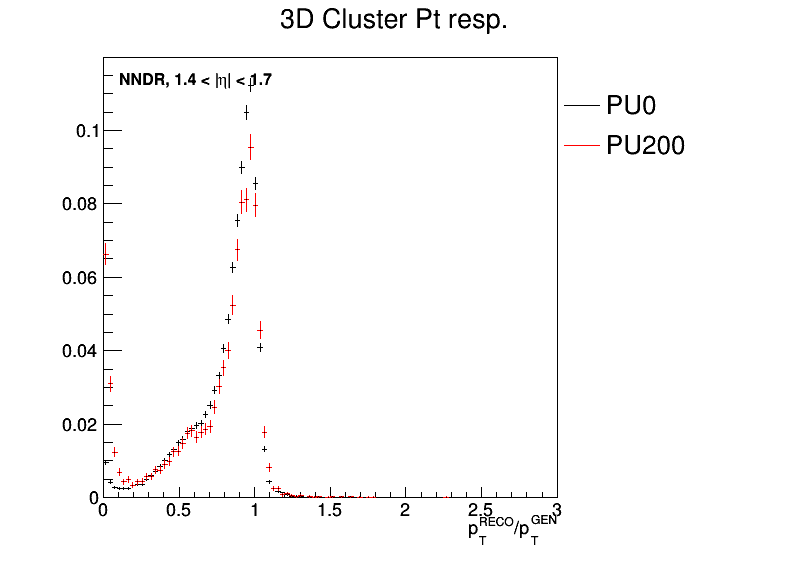

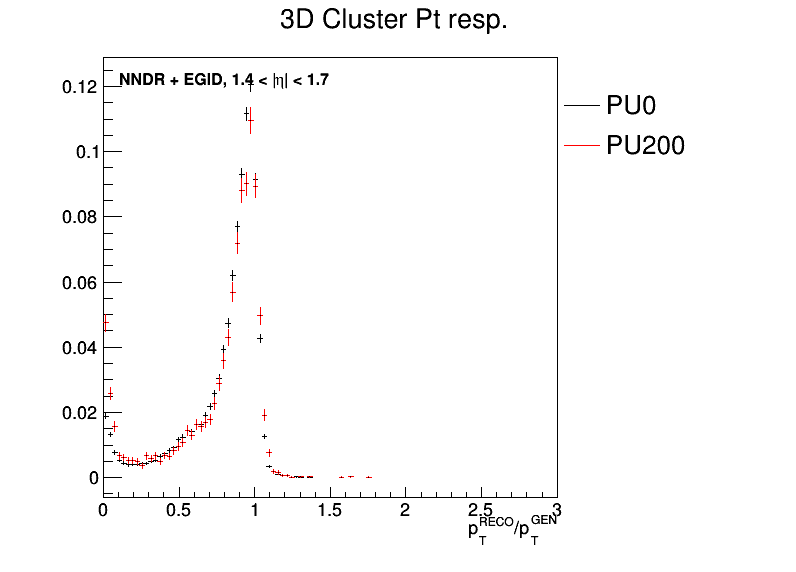

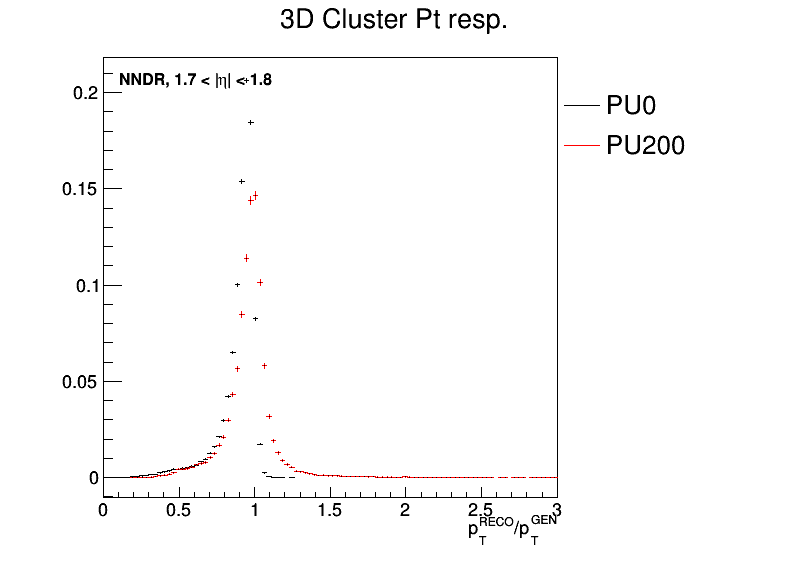

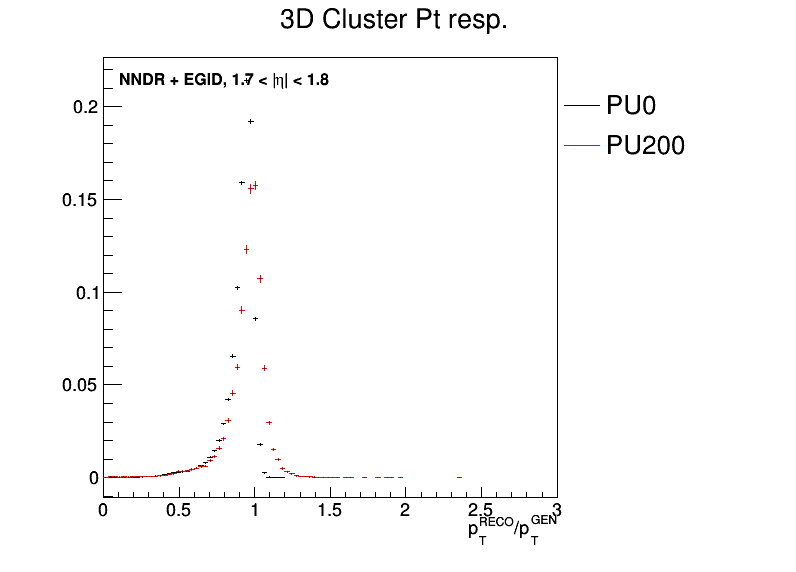

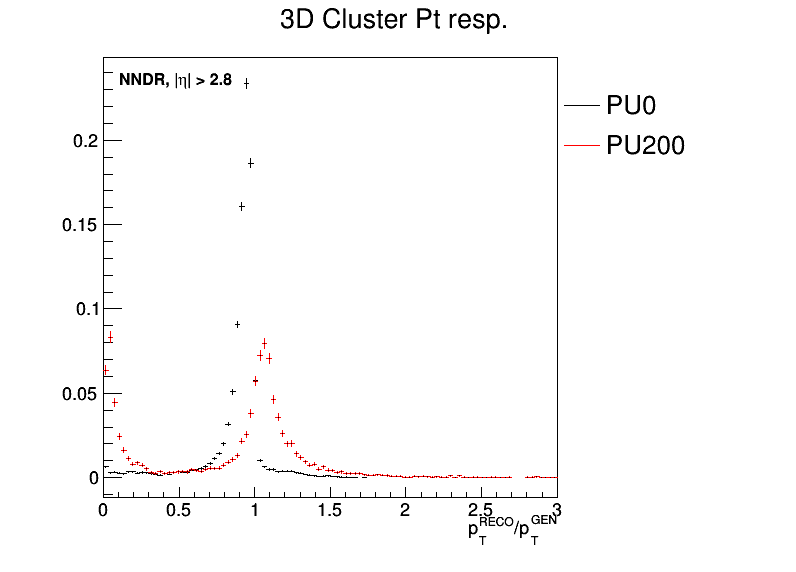

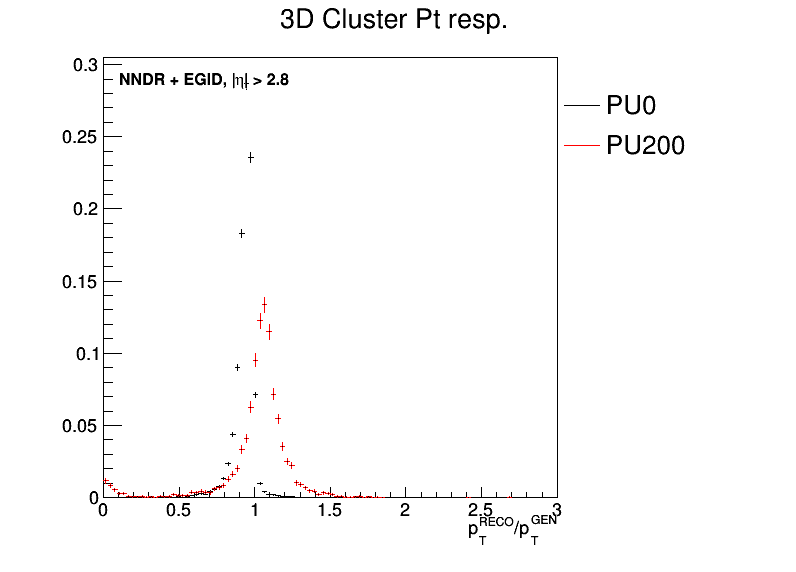

In [20]:
for particle in particles:
    for tp_set in ['DEF', 'DEF_em']:
        hByTPset = [histo.h_ptResp for histo in histo_reso_df.loc[tp_set, particle]]
        drawSame(hByTPset, labels, norm=True, text=titles_df.loc[tp_set, particle])


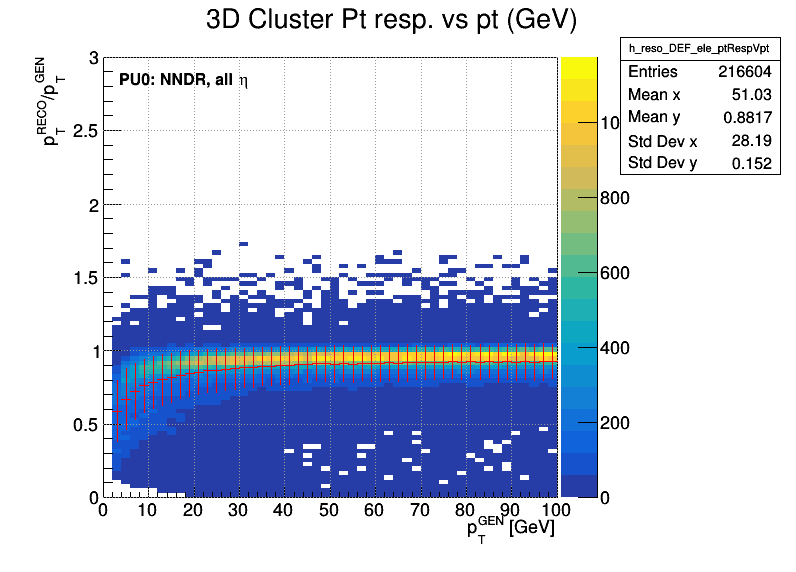

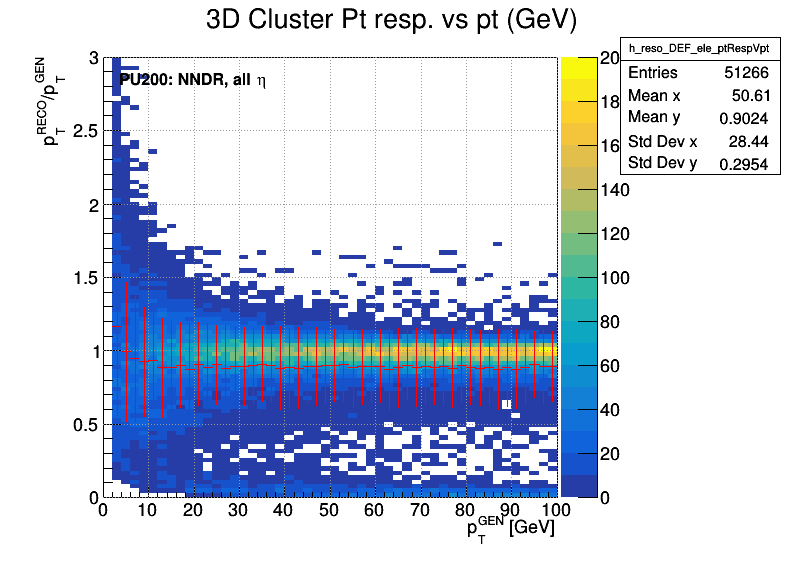

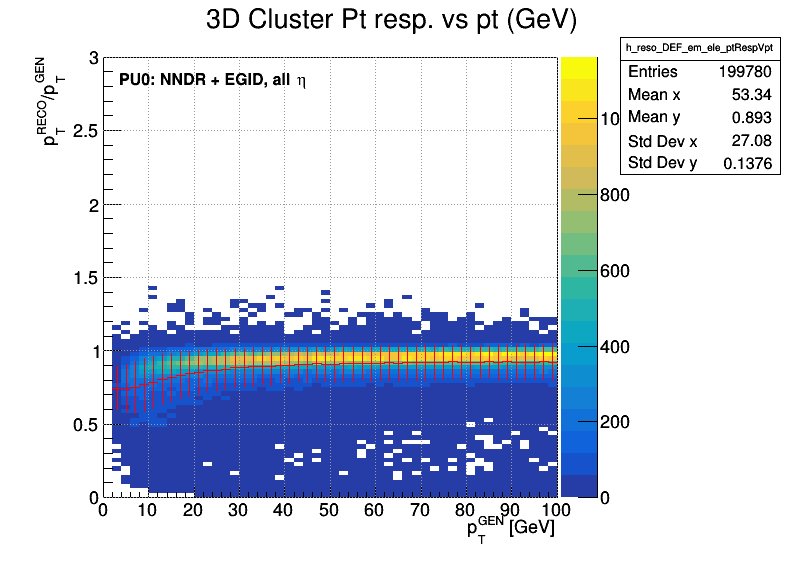

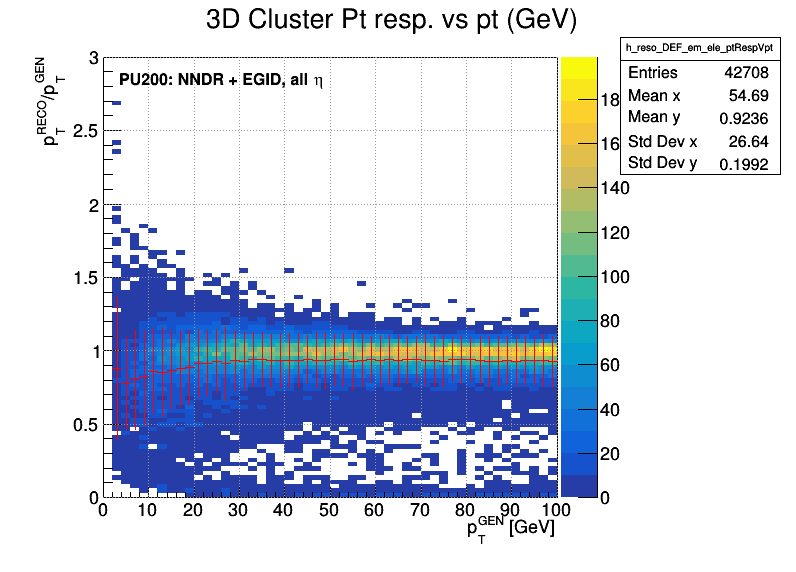

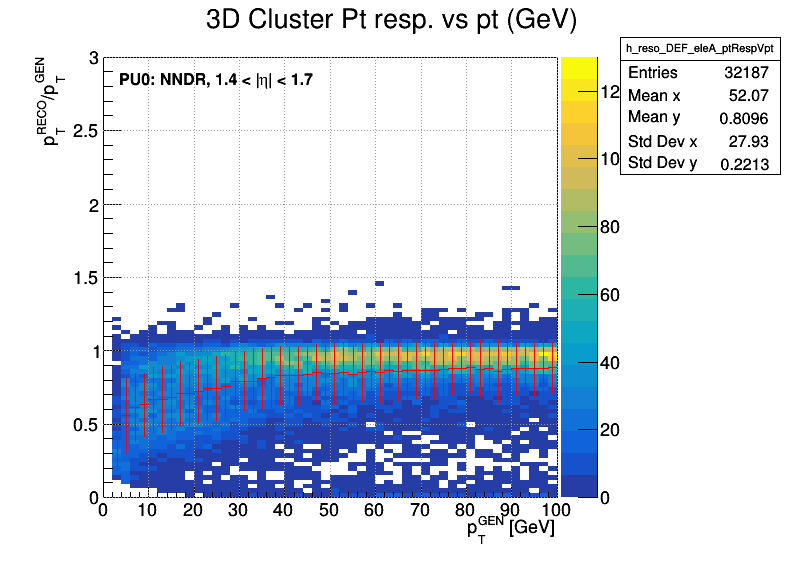

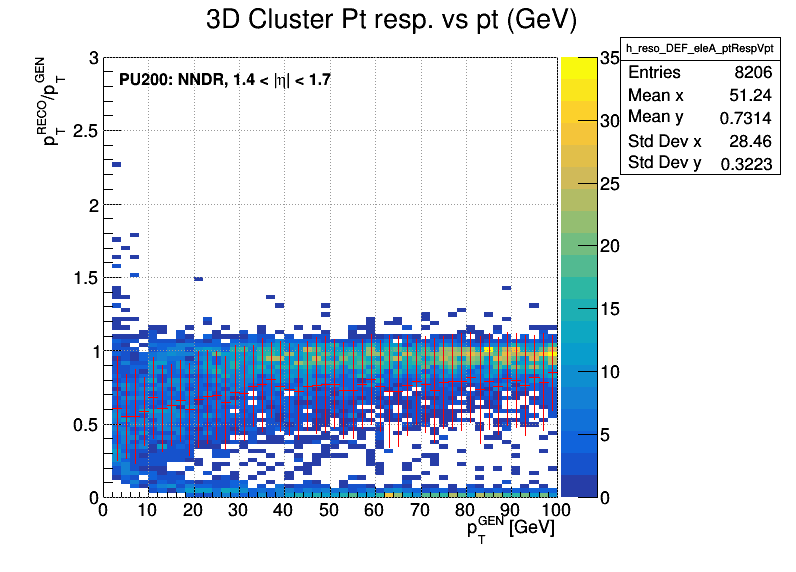

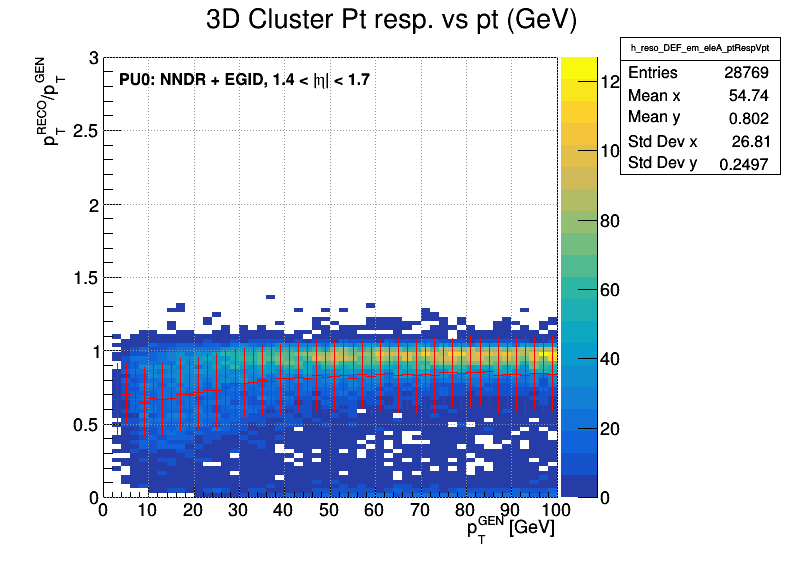

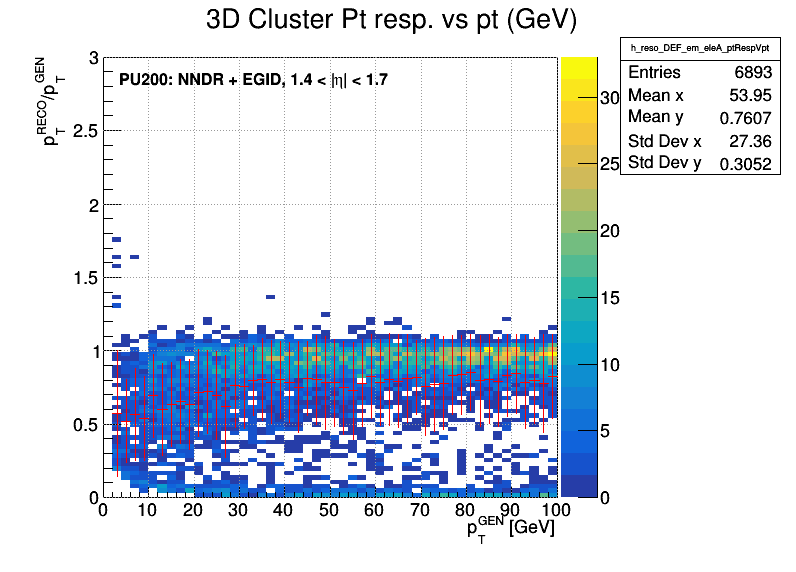

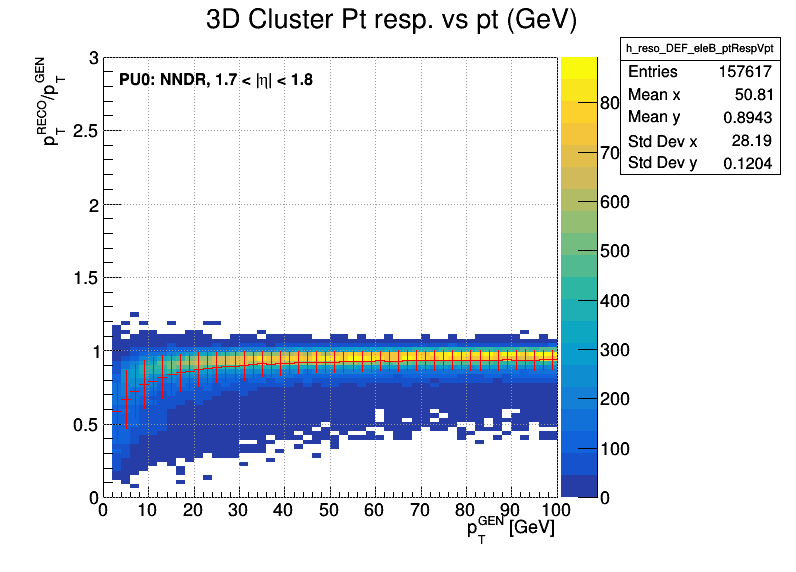

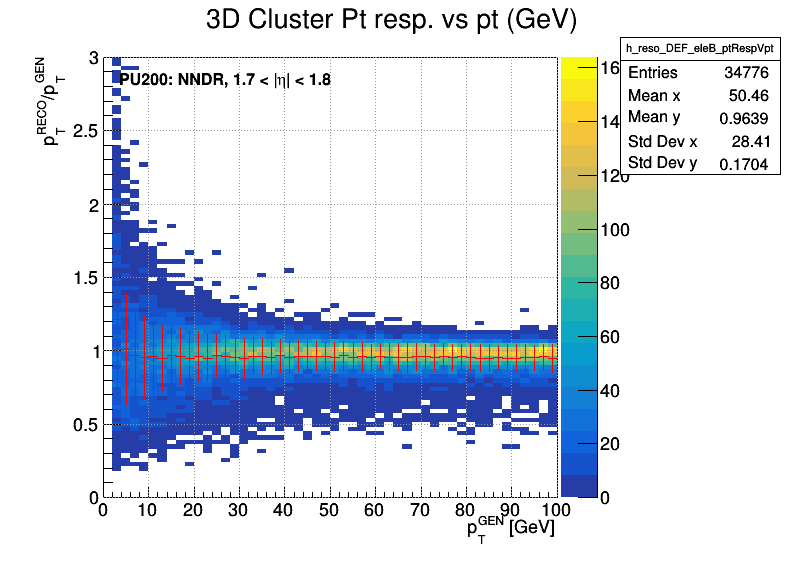

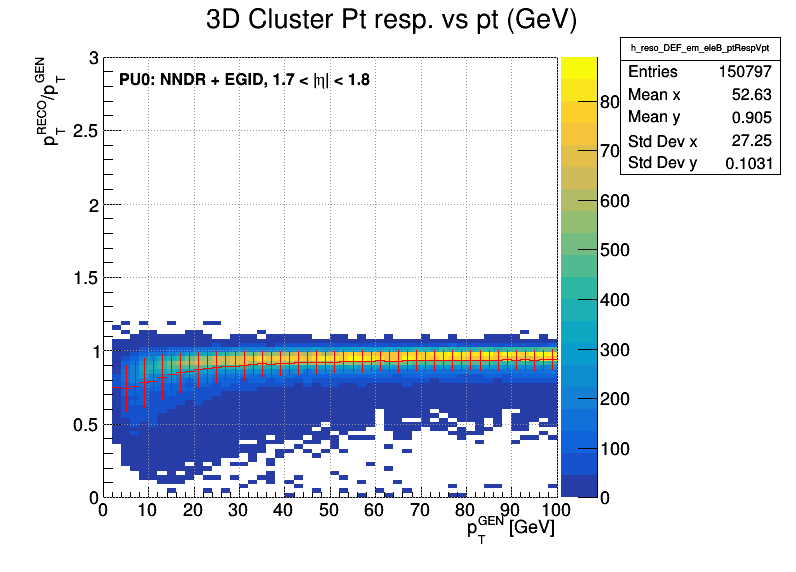

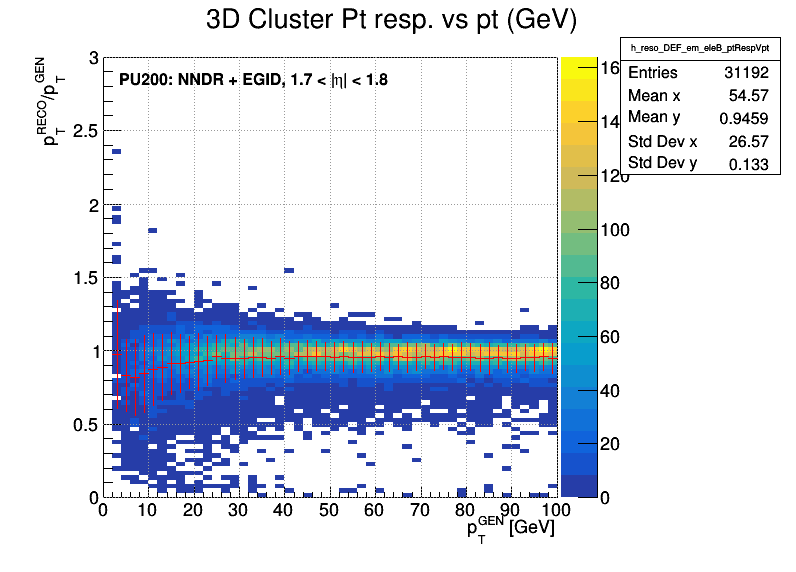

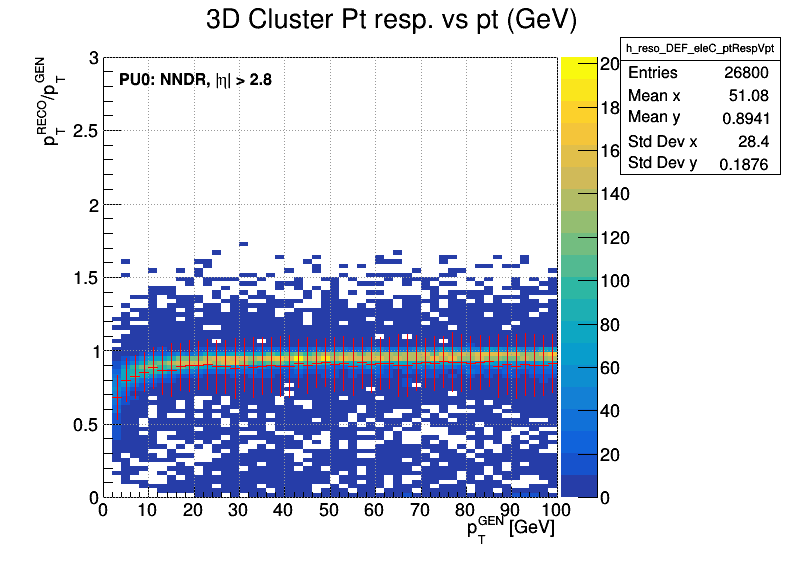

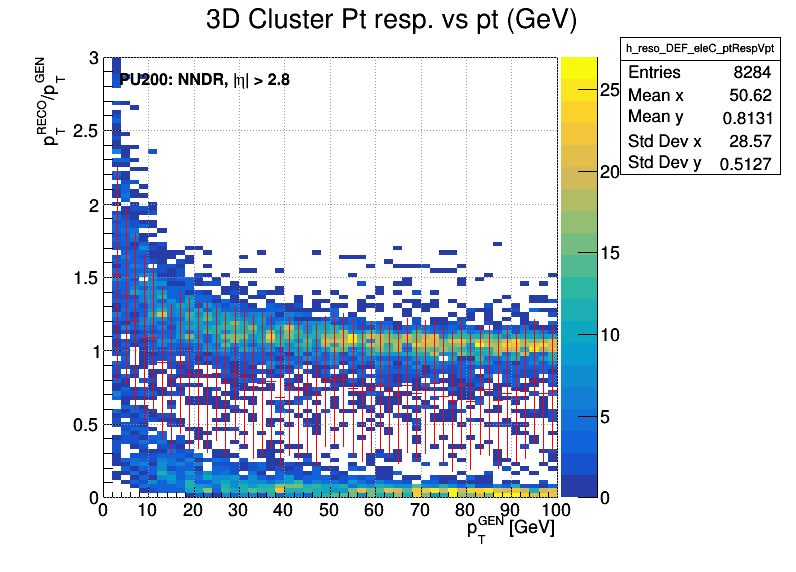

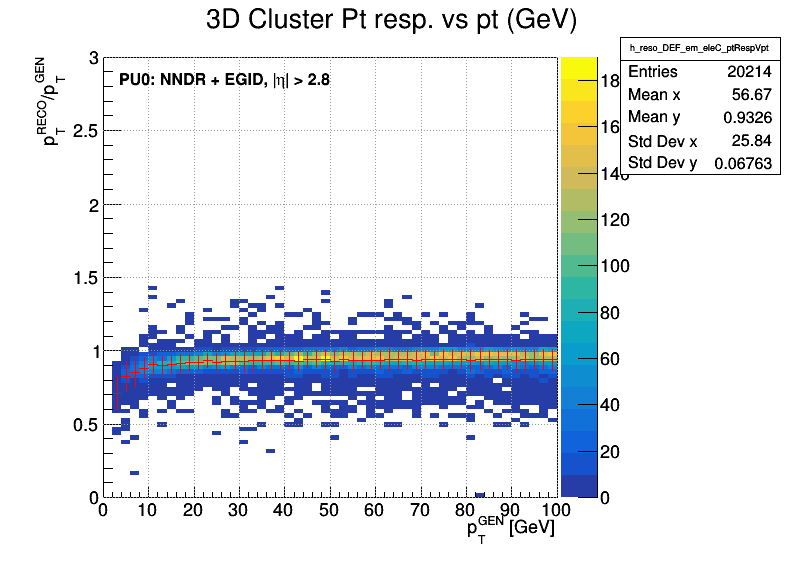

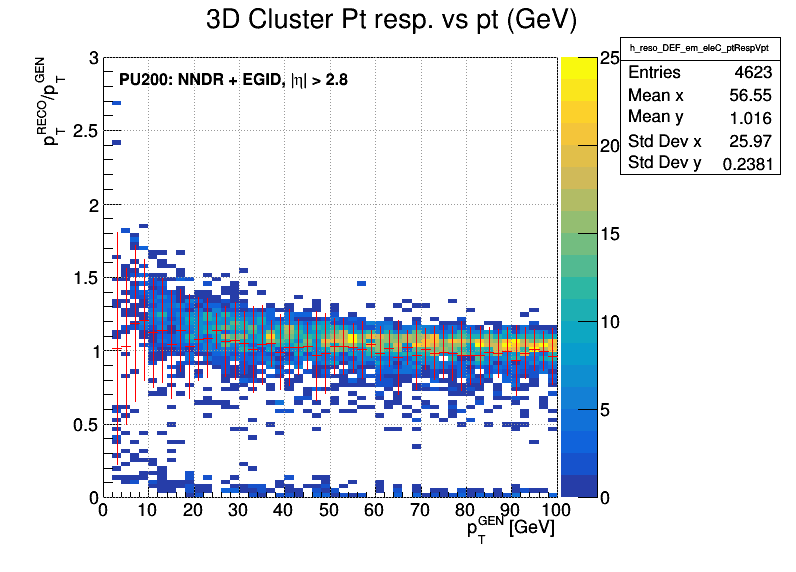

In [21]:
for particle in particles:
    for tp_set in ['DEF', 'DEF_em']:
        hByTPset = [histo.h_ptRespVpt for histo in histo_reso_df.loc[tp_set, particle]]
        drawSeveral(hByTPset, labels, options="COLZ", do_profile=True, text=titles_df.loc[tp_set, particle])


In [25]:
for particle in ['ele']:
    for tp_set in ['DEF', 'DEF_em']:
        hByTPset = [histo.h_ptRespVeta for histo in histo_reso_df.loc[tp_set, particle]]
        drawSeveral(hByTPset, labels, options="COLZ", do_profile=True, text=titles_df.loc[tp_set, particle])


#### All clusters in DR 0.2 from GEN

In [26]:
histo_resoCone_df = pd.DataFrame(index=tp_sets, columns=particles)
for tp_set in tp_sets:
    for particle in particles:
        histo_resoCone_df.loc[tp_set][particle] =  [histos.HistoSetReso('{}_{}'.format(tp_set, particle), sample.histo_file).hresoCone for sample in samples]
histo_resoCone_df

ele  \
DEF     [<ResoHistos h_resoCone_DEF_ele>, <ResoHistos ...   
DEF_em  [<ResoHistos h_resoCone_DEF_em_ele>, <ResoHist...   

                                                     eleA  \
DEF     [<ResoHistos h_resoCone_DEF_eleA>, <ResoHistos...   
DEF_em  [<ResoHistos h_resoCone_DEF_em_eleA>, <ResoHis...   

                                                     eleB  \
DEF     [<ResoHistos h_resoCone_DEF_eleB>, <ResoHistos...   
DEF_em  [<ResoHistos h_resoCone_DEF_em_eleB>, <ResoHis...   

                                                     eleC  
DEF     [<ResoHistos h_resoCone_DEF_eleC>, <ResoHistos...  
DEF_em  [<ResoHistos h_resoCone_DEF_em_eleC>, <ResoHis...

In [28]:
for particle in particles:
    for tp_set in ['DEF', 'DEF_em']:
        hByTPset = [histo.h_ptRes for histo in histo_resoCone_df.loc[tp_set, particle]]
        drawSame(hByTPset, labels, norm=True, text=titles_df.loc[tp_set, particle])


In [35]:
for particle in particles:
    for tp_set in ['DEF', 'DEF_em']:
        hByTPset = [histo.h_ptResp for histo in histo_resoCone_df.loc[tp_set, particle]]
        drawSame(hByTPset, labels, norm=True, text=titles_df.loc[tp_set, particle])


In [30]:
for particle in particles:
    for tp_set in ['DEF', 'DEF_em']:
        hByTPset = [histo.h_n010 for histo in histo_resoCone_df.loc[tp_set, particle]]
        drawSame(hByTPset, labels, norm=True, text=titles_df.loc[tp_set, particle])


In [31]:
for particle in particles:
    for tp_set in ['DEF', 'DEF_em']:
        hByTPset = [histo.h_n025 for histo in histo_resoCone_df.loc[tp_set, particle]]
        drawSame(hByTPset, labels, norm=True, text=titles_df.loc[tp_set, particle])


We now compare the 2 defitnitions (highest pt and all clusters in cone) for the same PU point

In [33]:
for particle in particles:
    for tp_set in ['DEF', 'DEF_em']:
        hByTPset_best = [histo.h_ptRes for histo in histo_reso_df.loc[tp_set, particle]]
        hByTPset_cone = [histo.h_ptRes for histo in histo_resoCone_df.loc[tp_set, particle]]

        drawSame([hByTPset_best[0], hByTPset_cone[0]], ['PU0 best', 'PU0 cone'], norm=True, text=titles_df.loc[tp_set, particle])
        drawSame([hByTPset_best[1], hByTPset_cone[1]], ['PU200 best', 'PU200 cone'], norm=True, text=titles_df.loc[tp_set, particle])


We now show the behavior of the pt residuals vs pt of the GEN particle

In [34]:
for algo in algos:
    hByAlgo = [histo.h_ptResVpt for histo in histosAlgos_all.loc[algo].hresoCone]
    #normalize(hclAll_pt35_layer, nevents_pt35)
    drawSeveral(hByAlgo, histosAlgos_all.loc[algo]['labels'], 'COLZ',do_profile=True)
    #print hByAlgo[0].GetName()

NameError: name 'algos' is not defined

In [ ]:
for algo in algos:
    hCl3D_ptResVpt_0 = [histo.h_ptResVpt.ProjectionY(uuid.uuid4().hex[:6], 1, 5) for histo in histosAlgos_all.loc[algo].hresoCone]
    for histo in hCl3D_ptResVpt_0:
        histo.SetTitle('3D cluster reso (GeV) for 1 < pt < 10 GeV')
    #     normalize(hByAlgo, histosAlgos_all.loc[algo]['norm'])
    drawSame(hCl3D_ptResVpt_0, histosAlgos_all.loc[algo]['labels'], norm=True)


In [ ]:
for algo in algos:
    hCl3D_ptResVpt_1 = [histo.h_ptResVpt.ProjectionY(uuid.uuid4().hex[:6], 6, 10) for histo in histosAlgos_all.loc[algo].hresoCone]
    for histo in hCl3D_ptResVpt_1:
        histo.SetTitle('3D cluster reso (GeV) for 10 < pt < 20 GeV')
    #     normalize(hByAlgo, histosAlgos_all.loc[algo]['norm'])
    drawSame(hCl3D_ptResVpt_1, histosAlgos_all.loc[algo]['labels'], norm=True)


In [ ]:
for algo in algos:
    hCl3D_ptResVpt_2 = [histo.h_ptResVpt.ProjectionY(uuid.uuid4().hex[:6], 11, 15) for histo in histosAlgos_all.loc[algo].hresoCone]
    for histo in hCl3D_ptResVpt_2:
        histo.SetTitle('3D cluster reso (GeV) for 20 < pt < 30 GeV')
    #     normalize(hByAlgo, histosAlgos_all.loc[algo]['norm'])
    drawSame(hCl3D_ptResVpt_2, histosAlgos_all.loc[algo]['labels'], norm=True)


In [ ]:
for algo in algos:
    hCl3D_ptResVpt_3 = [histo.h_ptResVpt.ProjectionY(uuid.uuid4().hex[:6], 16, 20) for histo in histosAlgos_all.loc[algo].hresoCone]
    for histo in hCl3D_ptResVpt_3:
        histo.SetTitle('3D cluster reso (GeV) for 30 < pt < 40 GeV')
    #     normalize(hByAlgo, histosAlgos_all.loc[algo]['norm'])
    drawSame(hCl3D_ptResVpt_3, histosAlgos_all.loc[algo]['labels'], norm=True)


In [ ]:
for algo in algos:
    hByAlgo = [histo.h_ptResVeta for histo in histosAlgos_all.loc[algo].hresoCone]
    #normalize(hclAll_pt35_layer, nevents_pt35)
    drawSeveral(hByAlgo, histosAlgos_all.loc[algo]['labels'], 'COLZ',do_profile=True)

In [ ]:
for algo in algos:
    hByAlgo = [histo.h_ptResVnclu for histo in histosAlgos_all.loc[algo].hresoCone]
    #normalize(hclAll_pt35_layer, nevents_pt35)
    drawSeveral(hByAlgo, histosAlgos_all.loc[algo]['labels'], 'COLZ',do_profile=True)

### Energy resolution


In [ ]:


for algo in algos:
    hByAlgo = [histo.h_energyRes for histo in histosAlgos_all.loc[algo].hreso]
    #normalize(hclAll_pt35_layer, nevents_pt35)
    drawSame(hByAlgo, histosAlgos_all.loc[algo]['labels'], norm=True)



In [ ]:

for s_id in range(0, len(samples)):
    labels_bySample = histosAlgos_all['labels'].apply(lambda x: x[s_id])
    hBySample = [histo.h_energyRes for histo in  histosAlgos_all['hreso'].apply(lambda x: x[s_id])]
    drawSame(hBySample, labels_bySample,'hist',logy=True)


## Postion resolution of 2D clusters

In [ ]:
for algo in algos:
    hByAlgo = [histo.h_xResVlayer for histo in histosAlgos_all.loc[algo].hreso2D]
    #normalize(hclAll_pt35_layer, nevents_pt35)
    drawSeveral(hByAlgo, histosAlgos_all.loc[algo]['labels'], 'COLZ',do_profile=True, miny=-2, maxy=2)

In [ ]:
for algo in algos:
    hByAlgo = [histo.h_xResVlayer.ProjectionY(uuid.uuid4().hex[:6], 1, 3) for histo in histosAlgos_all.loc[algo].hreso2D]
    for histo in hByAlgo:
        histo.SetTitle('2D cluster x reso (cm) for layer 1 and 3')
    #     normalize(hByAlgo, histosAlgos_all.loc[algo]['norm'])
    drawSame(hByAlgo, histosAlgos_all.loc[algo]['labels'], norm=True, options='hist')


In [ ]:
for algo in algos:
    hByAlgo = [histo.h_xResVlayer.ProjectionY(uuid.uuid4().hex[:6], 12, 15) for histo in histosAlgos_all.loc[algo].hreso2D]
    for histo in hByAlgo:
        histo.SetTitle('2D cluster x reso (cm) for layer 13 and 15')
    #     normalize(hByAlgo, histosAlgos_all.loc[algo]['norm'])
    drawSame(hByAlgo, histosAlgos_all.loc[algo]['labels'], norm=True, options='hist')


In [ ]:
for algo in algos:
    hByAlgo = [histo.h_yResVlayer for histo in histosAlgos_all.loc[algo].hreso2D]
    #normalize(hclAll_pt35_layer, nevents_pt35)
    drawSeveral(hByAlgo, histosAlgos_all.loc[algo]['labels'], 'COLZ',do_profile=True, miny=-2, maxy=2)